### Importation des packages

In [86]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
%matplotlib inline
import seaborn as sns
import pickle
import time
import logging
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
import cv2
import glob
import spacy
import contractions
import re
import string
import imageio
import imutils
import tqdm.notebook as tqdm

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
import tensorflow_hub as hub
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout 
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from keras.applications import resnet, ResNet50, vgg16, VGG19, vgg19, Xception, xception, InceptionV3, inception_v3

import gensim
from gensim.models import Word2Vec

import os
from os import listdir
import transformers
import sentence_transformers
from sentence_transformers import SentenceTransformer
from transformers import BertTokenizer, TFBertModel
from transformers import *

os.environ["TF_KERAS"]='1'

import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.stem.snowball import EnglishStemmer, FrenchStemmer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords

from collections import defaultdict

import multiprocessing
import umap.umap_ as umap
import umap
from umap import UMAP
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL
from PIL import Image, ImageOps
from sklearn import manifold, decomposition
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score, accuracy_score, auc, roc_auc_score, roc_curve
from sklearn import cluster, metrics, preprocessing, manifold, decomposition
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from glob import glob

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\JayCo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\JayCo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\JayCo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Fonctions

#### Fonctions générales

In [87]:
# Fonction de transformation des catégories : main_cat, sub_cat1, sub_cat2
def split_cat(category, level):
    category = category.split('["')[1].split('"]')[0]
    cat = category.split(' >> ')
    if(len(cat)) < 3:
        cat = [cat[0], cat[1], 'None']
        if(len(cat))<2:
            cat = [cat[0], 'None', 'None']
    return cat[level]

def split_categories_1(category):
    return split_cat(category,0)
def split_categories_2(category):
    return split_cat(category,1)
def split_categories_3(category):
    return split_cat(category,2)

def detail_categories(dataframe):
    dataframe['main_cat'] = dataframe['product_category_tree'].apply(split_categories_1)
    dataframe['sub_cat_1'] = dataframe['product_category_tree'].apply(split_categories_2)
    dataframe['sub_cat_2'] = dataframe['product_category_tree'].apply(split_categories_3)
    return dataframe.drop(['product_category_tree'], axis=1)

In [88]:
# Fonction de génération d'un plot de distribution d'une variables
def plot_distributions(dtf, x, max_cat=20, top=None, y=None, bins=None, figsize=(10,5)):
    # univariée
    if y is None:
        fig, ax = plt.subplots(figsize=figsize)
        fig.suptitle(x, fontsize=15)
        # catégorielle
        if dtf[x].nunique() <= max_cat:
            if top is None:
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            else:   
                dtf[x].reset_index().groupby(x).count().sort_values(by="index").tail(top).plot(kind="barh", legend=False, ax=ax).grid(axis='x')
            ax.set(ylabel=None)
        # numérique
        else:
            sns.distplot(dtf[x], hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
            ax.grid(True)
            ax.set(xlabel=None, yticklabels=[], yticks=[])

    # bivariée
    else:
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=figsize)
        fig.suptitle(x, fontsize=15)
        for i in dtf[y].unique():
            sns.distplot(dtf[dtf[y]==i][x], hist=True, kde=False, bins=bins, hist_kws={"alpha":0.8}, axlabel="", ax=ax[0])
            sns.distplot(dtf[dtf[y]==i][x], hist=False, kde=True, kde_kws={"shade":True}, axlabel="", ax=ax[1])
        ax[0].set(title="histogram")
        ax[0].grid(True)
        ax[0].legend(dtf[y].unique())
        ax[1].set(title="density")
        ax[1].grid(True)
    plt.show()

#### Fonctions relatives au traitement du texte

In [89]:
# Fonction de cleaning général (minuscules, symboles, ponctuations, URL)
def cleaning(text):
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Fonction de suppression des contractions
def del_contractions(data, col):
    data[col] = data[col].apply(lambda x:contractions.fix(x))
    

# Fonction de tokenisation (nltk)
def sentence_token(data, col1, col2):
    tokenizer = nltk.RegexpTokenizer(r'[a-zA-Z]\w+\'?\w*')
    data[col2] = data[col1].apply(lambda x : tokenizer.tokenize(x))
    

# Fonction de suppression des stop words
def del_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words


# Fonction de stemmatisation (méthode Snowball de nltk)
def snow_stemm(text):
    stemmer = nltk.SnowballStemmer("english")
    stems = [stemmer.stem(i) for i in text]
    return stems


# Fonction de lemmatisation
def lemm(text):
    lemmer = WordNetLemmatizer()
    lems = [lemmer.lemmatize(i) for i in text]
    return lems


# Fonction de comptage des mots, et visualisation graphique
def length(text):
    return len(text)

#### Fonctions relatives à la modélisation

In [90]:
# Fonction de sélection du nombre de dimensions après réduction
# afin de conserver un certain seuil de variance
def select_n_components(features, goal_var: float) -> int:

    # Création et fit du modèle
    tsvd = TruncatedSVD(n_components=features.shape[1]-1)
    tsvd.fit(features)
    tsvd_var_ratios = tsvd.explained_variance_ratio_

    # Initialisation
    total_variance = 0.0
    n_components = 0

    # boucle pour avoir le nombre de composante expliquant goal_var variance :
    for explained_variance in tsvd_var_ratios:
        total_variance += explained_variance
        n_components += 1
        if total_variance >= goal_var:
            break

    return n_components

In [91]:
# Fonction d'utilisation de USE
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [92]:
# Fonction de réduction de dimension, incluant SVD / T-SNE / UMAP
def reduction_fct(features, reduc='SVD'):

    if reduc == 'SVD':
        n_comp = select_n_components(features, goal_var=0.99)
        print(f"Number of dimensions before TSVD: {features.shape[1]}")
        print(
            f"Number of dimensions after TSVD (99% var. explained): {n_comp}")
        modelSVD = TruncatedSVD(n_components=n_comp, random_state=42)
        reduc_X = modelSVD.fit_transform(features)
        return reduc_X

    elif reduc == 'TSNE':
        tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
        reduc_X = tsne.fit_transform(features)
        return reduc_X

    elif reduc == 'UMAP':
        modelUMAP = UMAP(n_neighbors=200,
                         min_dist=1,
                         n_components=2,
                         random_state=42)
        reduc_X = modelUMAP.fit_transform(features)
        return reduc_X

    else:
        print("La méthode de réduction saisie est incorrecte")

In [93]:
# Fonction de modélisation via KMeans
# et évaluation par ARI
def kmeans_fct(features, y_categ):

    # Détermination des clusters à partir des données après Tsne
    num_labels = len(set(y_categ))
    cls = KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(features)
    ARI = np.round(adjusted_rand_score(y_categ, cls.labels_), 4)
    print("ARI : ", ARI)

    return ARI, cls.labels_

In [94]:
# Fonction de représentation graphique après réduction de dimension
def reduc_visu_fct(reduc_X, target, labels):

    # Encodage des targets pour la couleur des clusters
    LE = LabelEncoder()
    y_categ = LE.fit_transform(target)
    categ = list(set(target))

    # représentation graphique
    fig = plt.figure(figsize=(20, 8))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=y_categ, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[
              0], labels=categ, loc="best", title="Categorie")
    plt.title('Représentation des produits par catégories réelles')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(reduc_X[:, 0], reduc_X[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(
        labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')

    plt.show()

In [95]:
# Fonction de préparation des phrases (BERT tokenizer)
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features BERT
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### Fonctions relatives à l'évaluation des modèles

In [96]:
# Fonction pour matrice de confusion (prédictions)
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)
    
    corresp = np.argmax(conf_mat, axis=0)
    print ("Correspondance des clusters : ", corresp)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x]) 
    
    return labels['y_pred_transform']

In [97]:
# Fonction de génération de la matrice de confusion
def CM_matrix(data, col):
    conf_mat = metrics.confusion_matrix(data[col], cls.labels_)
    cls_labels_transform = conf_mat_transform(data[col], cls.labels_)
    conf_mat = metrics.confusion_matrix(data[col], cls_labels_transform)
    ARI = np.round(metrics.adjusted_rand_score(data[col], cls.labels_),4)
    accuracy = round(metrics.accuracy_score(data[col], cls.labels_), 4)
    
    print('Accuracy : {}'.format(accuracy))
    print()
    print(conf_mat)
    print()
    print(metrics.classification_report(data[col], cls_labels_transform))
    df_cm = pd.DataFrame(conf_mat, index = [label for label in l_cat],
                  columns = [i for i in "0123456"])
    plt.figure(figsize = (6, 7))
    sns.heatmap(df_cm, annot=True, cmap="Blues")

# Chemins

In [98]:
# Définition des chemins sources
path = './Flipkart/'
path_img = './Images/'

# Fichier Flipkart

In [99]:
# Ouverture et description simple du fichier Flipkart
df_flipkart = pd.read_csv(path+'flipkart_com-ecommerce_sample_1050.csv')
display(df_flipkart.head())
display(df_flipkart.info())

uniq_id            crawl_timestamp   
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000  \
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url   
0  http://www.flipkart.com/elegance-polyester-mul...  \
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name   
0  Elegance Polyester Multicolor Abstract Eyelet ...  \
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid   
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z  \
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image   
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  \
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description   
0                    False  Key Features of Elegance Polyester Multicolor ...  \
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand   
0  No rating available  No rating available               Elegance  \
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

None

# Exploration du dataset (EDA)

### Valeurs nulles

In [100]:
# Analyse des valeurs nulles (% par colonne)
null_data = (df_flipkart.isna().sum()/df_flipkart.shape[0])*100
null_data

uniq_id                     0.000000
crawl_timestamp             0.000000
product_url                 0.000000
product_name                0.000000
product_category_tree       0.000000
pid                         0.000000
retail_price                0.095238
discounted_price            0.095238
image                       0.000000
is_FK_Advantage_product     0.000000
description                 0.000000
product_rating              0.000000
overall_rating              0.000000
brand                      32.190476
product_specifications      0.095238
dtype: float64

Les valeurs nulles concernent des features dont nous n'avons pas l'utilité ('retail_price', 'discounted_price', 'brand').

### Doublons

In [101]:
# Check doublons

df_flipkart.duplicated().value_counts()

False    1050
Name: count, dtype: int64

Le fichier ne comporte pas de doublons

### Traitement des catégories

Nous utiliserons la feature 'product_category_tree' pour déterminer la catégorie principale de chaque produit, ainsi que ses deux sous catégories.

In [102]:
# Valeurs différentes dans la variable 'product_category_tree' et exemple
display(df_flipkart['product_category_tree'].nunique())
display(df_flipkart['product_category_tree'].iloc[0])

642

'["Home Furnishing >> Curtains & Accessories >> Curtains >> Elegance Polyester Multicolor Abstract Eyelet Do..."]'

In [103]:
# Application de la fonction de split des catégories
df_flipkart = detail_categories(df_flipkart)

# Visualisation et comptage des catégories
display(df_flipkart[['main_cat', 'sub_cat_1', 'sub_cat_2']].iloc[0])
display(df_flipkart['main_cat'].value_counts())
display(df_flipkart[['main_cat', 'sub_cat_1', 'sub_cat_2']].nunique())

main_cat            Home Furnishing
sub_cat_1    Curtains & Accessories
sub_cat_2                  Curtains
Name: 0, dtype: object

main_cat
Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: count, dtype: int64

main_cat       7
sub_cat_1     62
sub_cat_2    242
dtype: int64

Nous obtenons donc 7 catégories principales, chacune composée de 150 produits.

### Cleaning du texte 'description'

Intervenons sur la feature 'description' afin de rendre le texte exploitable pour la modélisation (classification non supervisée).

In [104]:
# Copie du fichier avec les features retenues
df_cat = df_flipkart[['uniq_id', 
                      'crawl_timestamp', 
                      'product_name', 
                      'image', 
                      'description',
                      'product_specifications',
                      'main_cat',
                      'sub_cat_1',
                      'sub_cat_2']].copy()

# Affichage d'un exemple de description
df_cat['description'].iloc[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

Appliquons l'ensemble des méthodes définies pour cleaner et traiter le texte de la feature 'description'. Le résultat est stocké dans une nouvelle feature 'clean_description'.

In [105]:
# Création d'une nouvelle feature pour les descriptions cleanées
df_cat['clean_description'] = df_cat['description'].copy()

# FONCTIONS DE TRAITEMENT/CLEANING
# cleaning général
df_cat['clean_description'] = df_cat['description'].apply(lambda x: cleaning(x))
# Suppression contractions
del_contractions(df_cat, 'clean_description')
# Tokenisation des phrases
sentence_token(df_cat, 'description', 'clean_description')
# Suppression des stop words
df_cat['clean_description'] = df_cat['clean_description'].apply(lambda x : del_stopwords(x))
# Stemmatisation
df_cat['clean_description'] = df_cat['clean_description'].apply(lambda x : snow_stemm(x))
# Lemmatisation
df_cat['clean_description'] = df_cat['clean_description'].apply(lambda x : lemm(x))

In [106]:
# Affichage de l'exemple
df_cat['clean_description'].iloc[0]

['key',
 'featur',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'floral',
 'curtain',
 'eleg',
 'polyest',
 'multicolor',
 'abstract',
 'eyelet',
 'door',
 'curtain',
 'cm',
 'height',
 'pack',
 'price',
 'r',
 'this',
 'curtain',
 'enhanc',
 'look',
 'interior',
 'this',
 'curtain',
 'made',
 'high',
 'qualiti',
 'polyest',
 'fabric',
 'it',
 'featur',
 'eyelet',
 'style',
 'stitch',
 'metal',
 'ring',
 'it',
 'make',
 'room',
 'environ',
 'romant',
 'love',
 'this',
 'curtain',
 'ant',
 'wrinkl',
 'anti',
 'shrinkag',
 'eleg',
 'appar',
 'give',
 'home',
 'bright',
 'modernist',
 'appeal',
 'design',
 'the',
 'surreal',
 'attent',
 'sure',
 'steal',
 'heart',
 'these',
 'contemporari',
 'eyelet',
 'valanc',
 'curtain',
 'slide',
 'smooth',
 'draw',
 'apart',
 'first',
 'thing',
 'morn',
 'welcom',
 'bright',
 'sun',
 'ray',
 'want',
 'wish',
 'good',
 'morn',
 'whole',
 'world',
 'draw',
 'close',
 'even',
 'creat',
 'special',
 'moment',
 'joyous

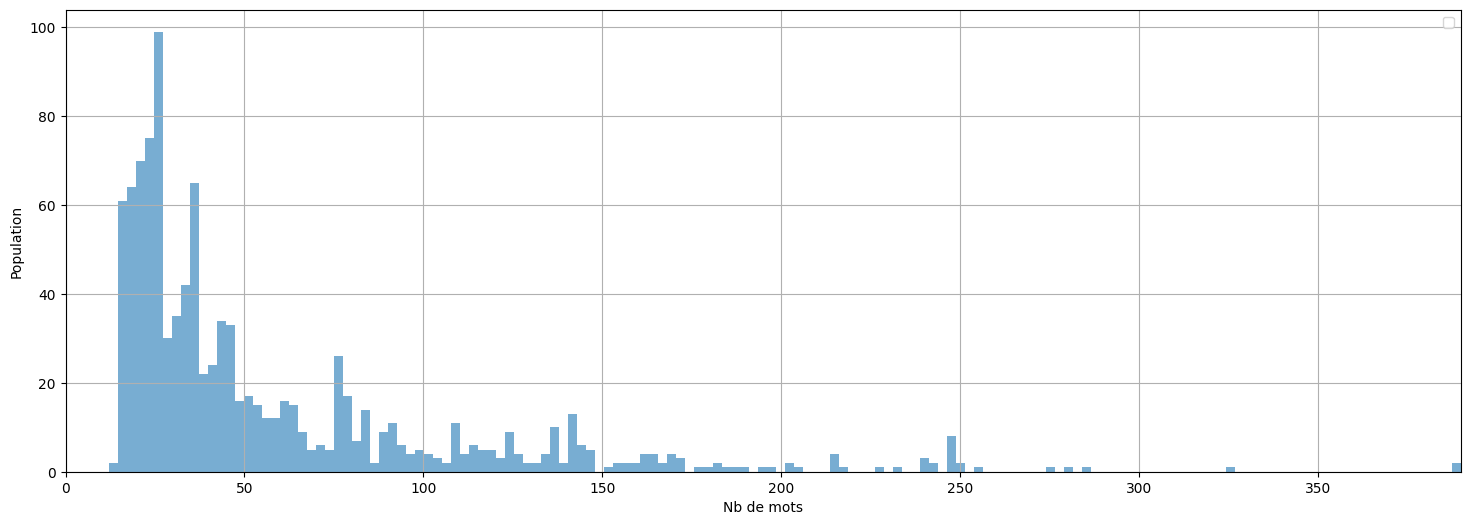

In [107]:
# Comptage du nombre de mots dans 'clean_description'
df_cat['length'] = df_cat['clean_description'].apply(length)

# Représentation graphique
plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 150
plt.hist(df_cat['length'], alpha = 0.6, bins=bins)
plt.xlabel('Nb de mots')
plt.ylabel('Nombre')
plt.legend(loc='upper right')
plt.xlim(0,df_cat['length'].max())
plt.grid()
plt.show()

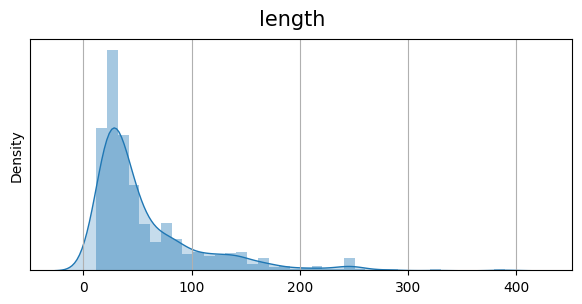

In [108]:
# Distribution : longueur des descriptions
plot_distributions(df_cat, x='length', top=None, figsize=(7,3))

#### Sauvegarde du fichier cleané

Enregistrons le fichier cleané (clean_data) au format .csv, afin de l'exploiter pour la modélisation.

In [109]:
df_cat.to_csv(path+'clean_data.csv')

# Paramétrages pour les essais de classification

#### Ouverture du fichier cleané

In [110]:
# Définition des chemins
path = './Flipkart/'

# Ouverture
clean_data = pd.read_csv(path+'clean_data.csv')
clean_data.drop(['Unnamed: 0', 
                 'crawl_timestamp', 
                 'product_name', 
                 'image', 
                 'product_specifications',
                 'sub_cat_1', 
                 'sub_cat_2'
                ], axis = 1, inplace = True)
display(clean_data.shape)
clean_data.head()

(1050, 5)

uniq_id   
0  55b85ea15a1536d46b7190ad6fff8ce7  \
1  7b72c92c2f6c40268628ec5f14c6d590   
2  64d5d4a258243731dc7bbb1eef49ad74   
3  d4684dcdc759dd9cdf41504698d737d8   
4  6325b6870c54cd47be6ebfbffa620ec7   

                                         description         main_cat   
0  Key Features of Elegance Polyester Multicolor ...  Home Furnishing  \
1  Specifications of Sathiyas Cotton Bath Towel (...        Baby Care   
2  Key Features of Eurospa Cotton Terry Face Towe...        Baby Care   
3  Key Features of SANTOSH ROYAL FASHION Cotton P...  Home Furnishing   
4  Key Features of Jaipur Print Cotton Floral Kin...  Home Furnishing   

                                   clean_description  length  
0  ['key', 'featur', 'eleg', 'polyest', 'multicol...     162  
1  ['specif', 'sathiya', 'cotton', 'bath', 'towel...      64  
2  ['key', 'featur', 'eurospa', 'cotton', 'terri'...     156  
3  ['key', 'featur', 'santosh', 'royal', 'fashion...     118  
4  ['key', 'featur', 'jaipur', 'print', 'cotton',...     157

#### Paramétrages

In [111]:
# Liste nominative des différentes catégories réelles
l_cat = list(set(clean_data['main_cat']))

# Génération d'une liste de stockage des résultats de modélisation
Results = np.empty(shape=[0, 3])

# Liste des catégories réelles de la base de données (liste)
y_cat_num = [(1-l_cat.index(clean_data.iloc[i]['main_cat'])) for i in range(len(clean_data))]

# Longeur max description
Max_len = clean_data['clean_description'].str.len().max()

print('Catégories réelles : \n{}'.format(l_cat))
print()
print('Longueur max description : \n{}'.format(Max_len))

Catégories réelles : 
['Baby Care', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Beauty and Personal Care', 'Watches', 'Computers']

Longueur max desription : 
3588


# Essais de classification

#### PLAN D'APPROCHE DE LA CLASSIFICATION   
  
Pour chaque méthode, nous procèderons à une réduction de dimension par UMAP, SVD et T-SNE.  
Nosu représenterons graphiquement chaque méthode de réduction, et produirons une matrice de confusion sur la réduction effectuée via le T-SNE.
  
Méthodes de modélisation utilisées :
    
1. Bag of Words (BoW)  
    A. CounterVectorizer  
    B. TF-IDF  
2. Word Embedding  
    A. Word2Vec (cBoW)   
    B. FastText (cBoW)  
    C. BERT (bert base uncased)  
    D. BERT (Hub TensorFlow)  
3. Sentence Embedding  
    A. USE (Universal Sentence Encoder)  
    B. Sentence BERT  

## 1. Bag of Words (BoW)

### A. CounterVectorizer

In [112]:
cvect = CountVectorizer(max_df=0.95, min_df=1)
cv_fit = cvect.fit(clean_data['clean_description'])
cv_transform = cvect.transform(clean_data['clean_description']) 

#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 4339
Number of dimensions after TSVD (99% var. explained): 592
ARI :  0.0486


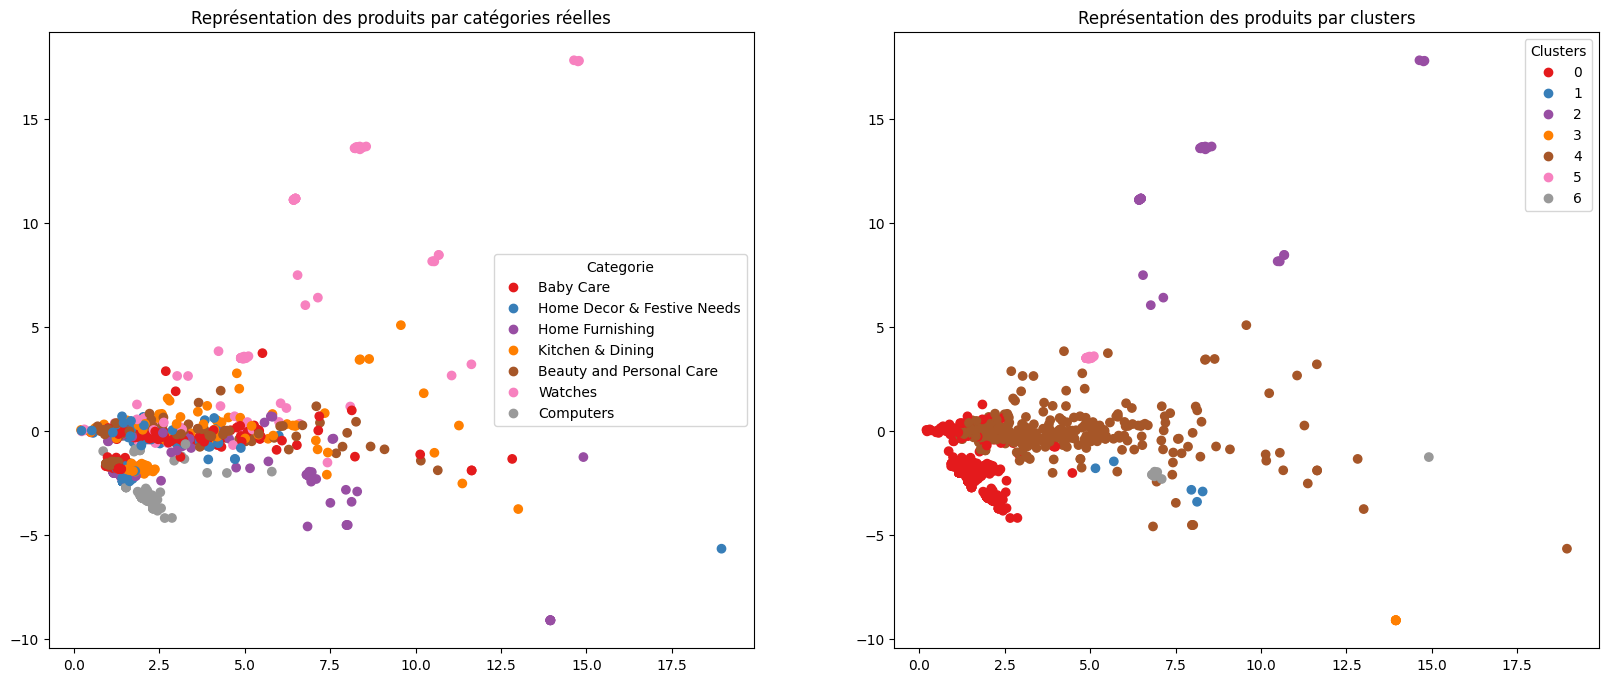

In [113]:
X_reduc = reduction_fct(cv_transform, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['CounterVectorizer', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.2845


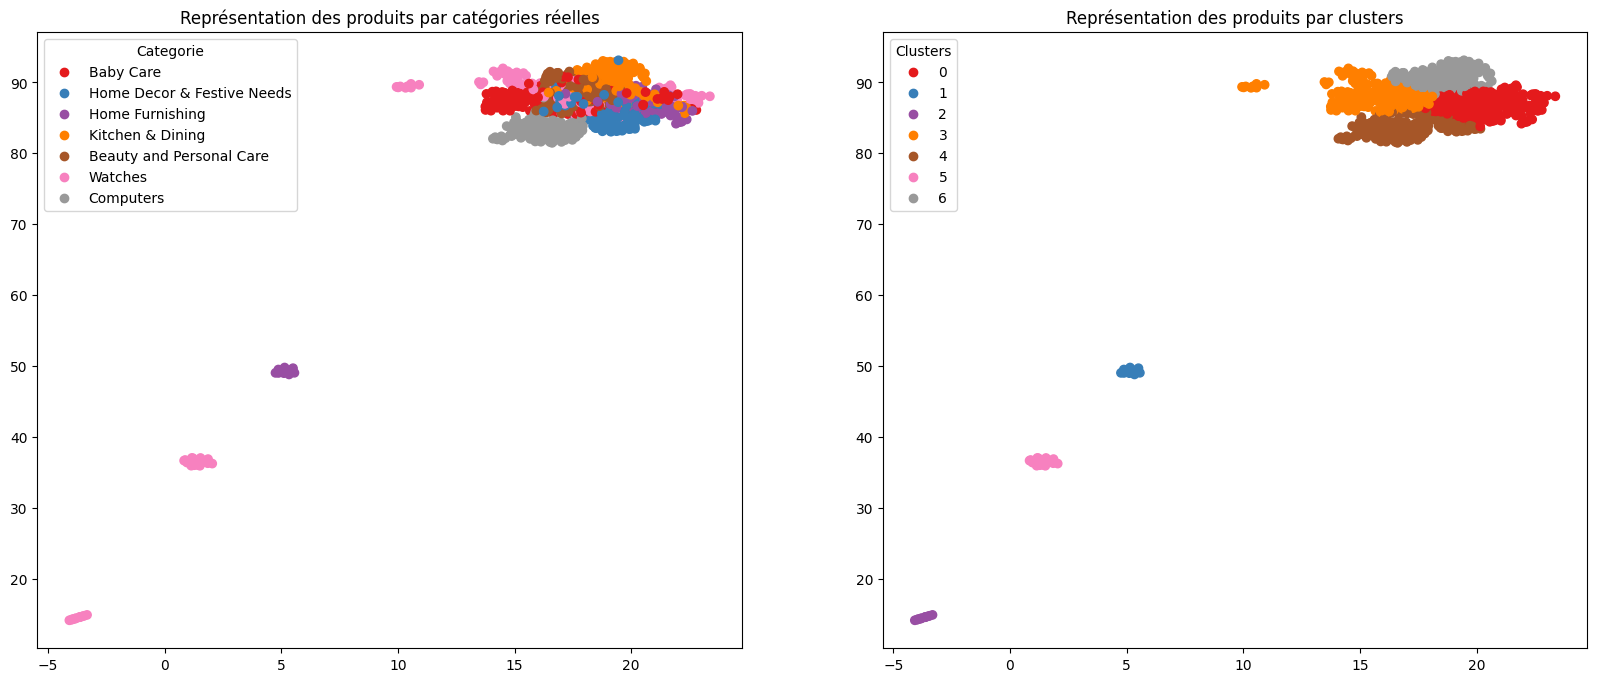

In [114]:
X_reduc = reduction_fct(cv_transform, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['CounterVectorizer', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.425


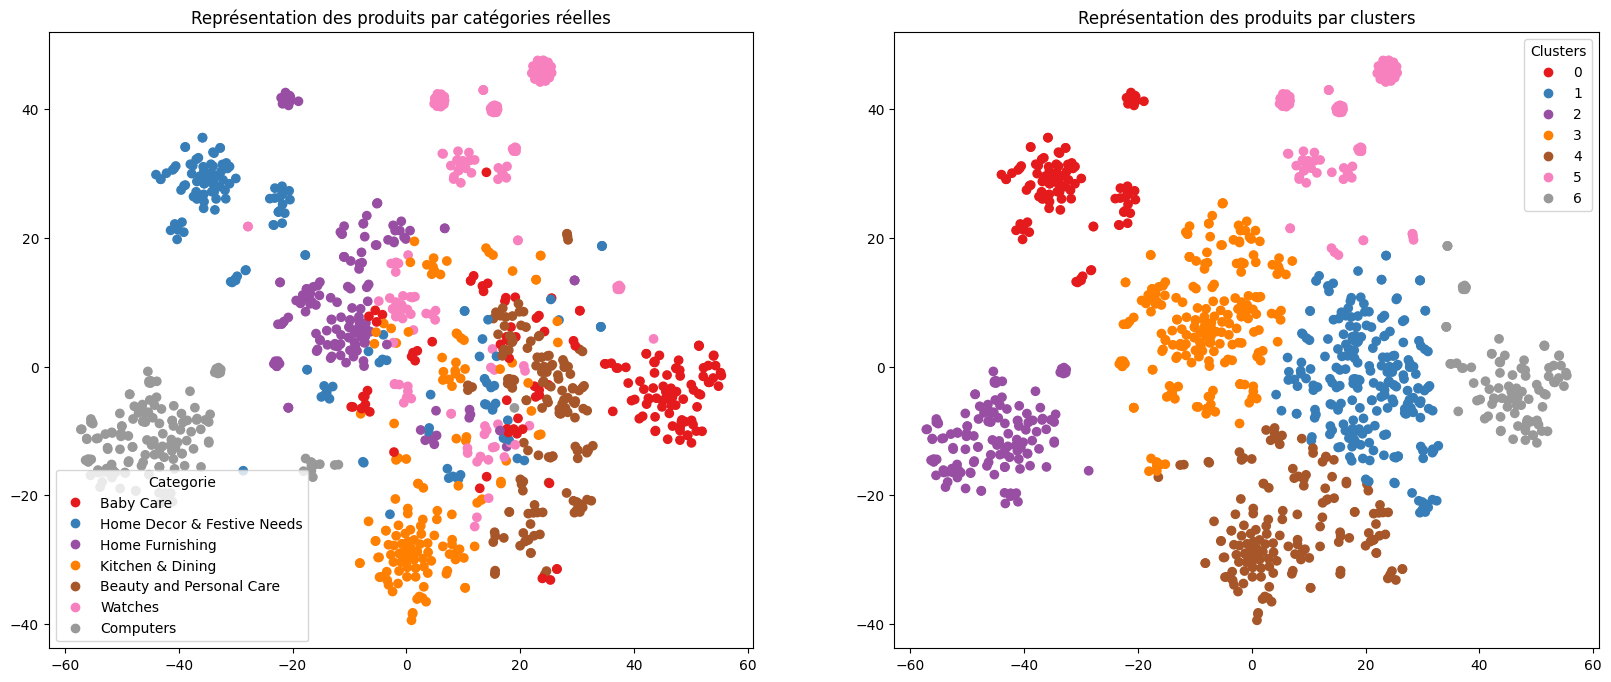

In [115]:
X_reduc = reduction_fct(cv_transform, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['CounterVectorizer', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [5 3 6 0 4 1 2]
Accuracy : 0.1314

[[ 85   0  18   7  39   1   0]
 [  6  94  16  10  23   0   1]
 [  0  11 123   5   9   2   0]
 [  0   0  18  99  30   3   0]
 [  0   0   0  29 117   4   0]
 [  6   2  40   9  17  76   0]
 [  0   0   8   3   1   0 138]]

              precision    recall  f1-score   support

           0       0.88      0.57      0.69       150
           1       0.88      0.63      0.73       150
           2       0.55      0.82      0.66       150
           3       0.61      0.66      0.63       150
           4       0.50      0.78      0.61       150
           5       0.88      0.51      0.64       150
           6       0.99      0.92      0.96       150

    accuracy                           0.70      1050
   macro avg       0.76      0.70      0.70      1050
weighted avg       0.76      0.70      0.70      1050



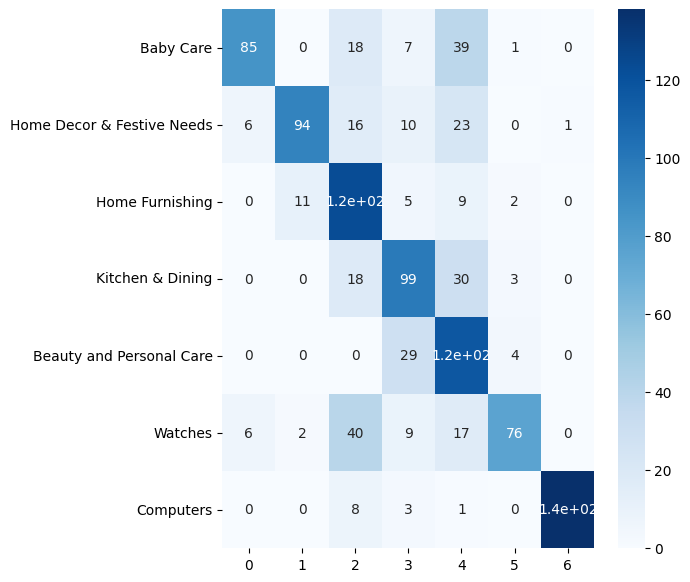

In [116]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(cv_transform)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### B. TF-IDF

In [117]:
ctf = TfidfVectorizer(max_df=0.95, min_df=1)
ctf_fit = ctf.fit(clean_data['clean_description'])
ctf_transform = ctf.transform(clean_data['clean_description']) 

#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 4339
Number of dimensions after TSVD (99% var. explained): 845
ARI :  0.2589


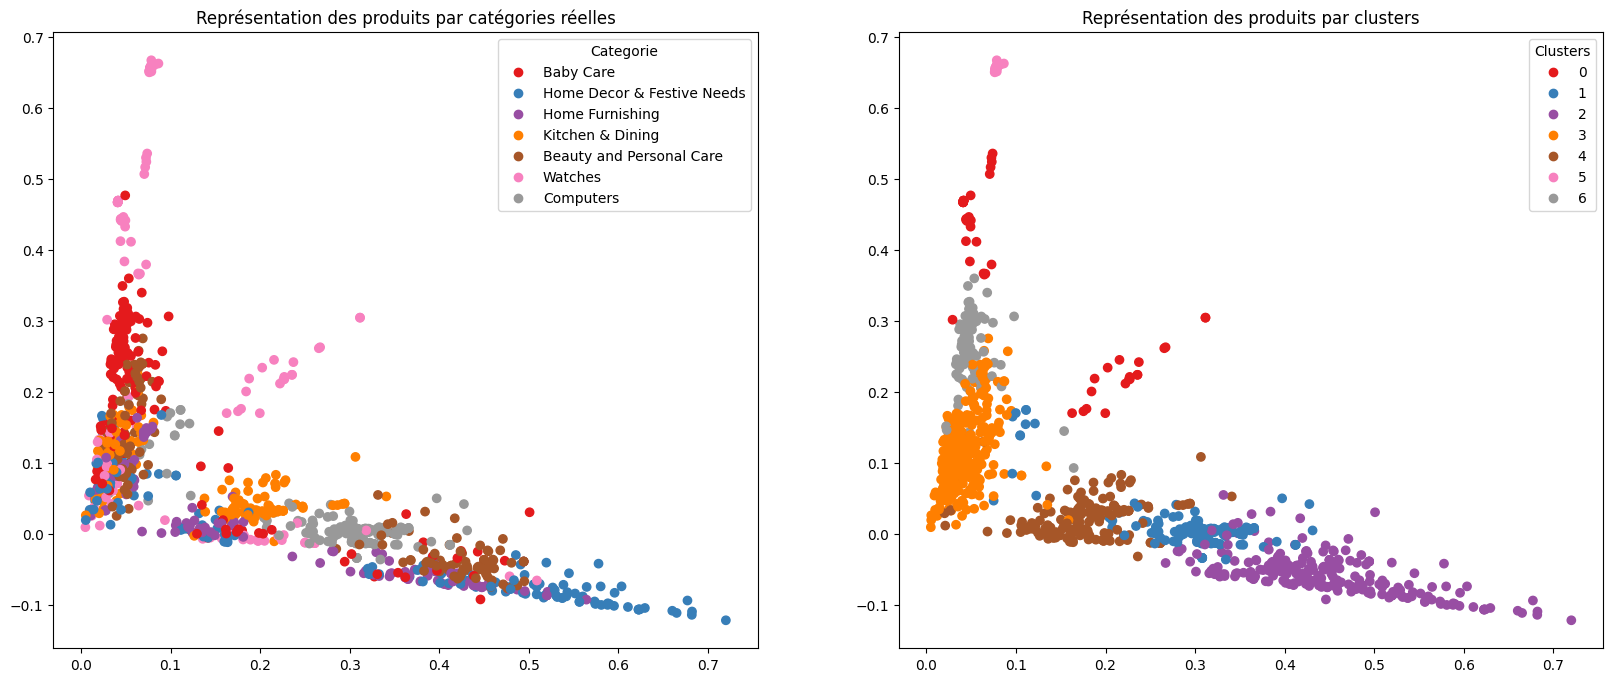

In [118]:
X_reduc = reduction_fct(ctf_transform, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['TF-IDF', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.3226


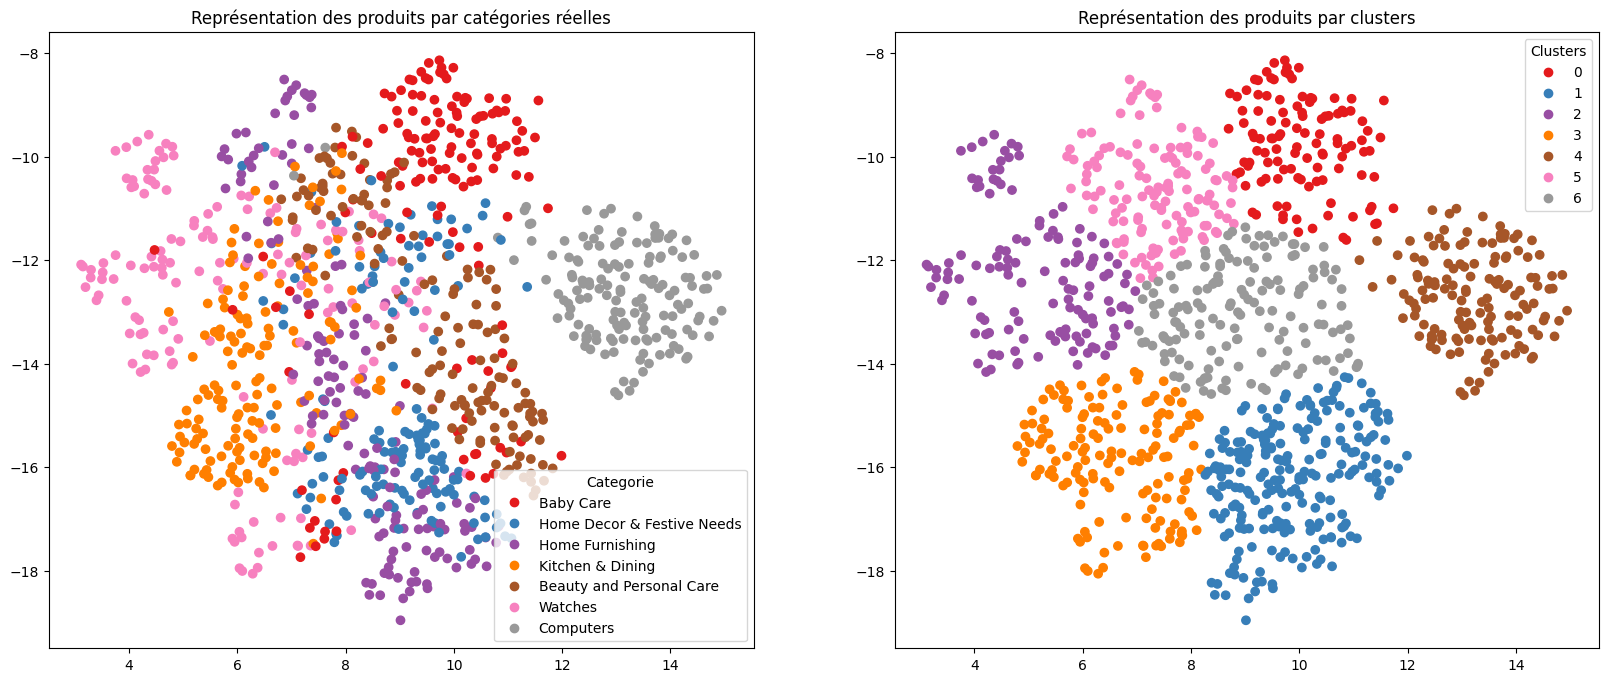

In [119]:
X_reduc = reduction_fct(ctf_transform, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['TF-IDF', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.4459


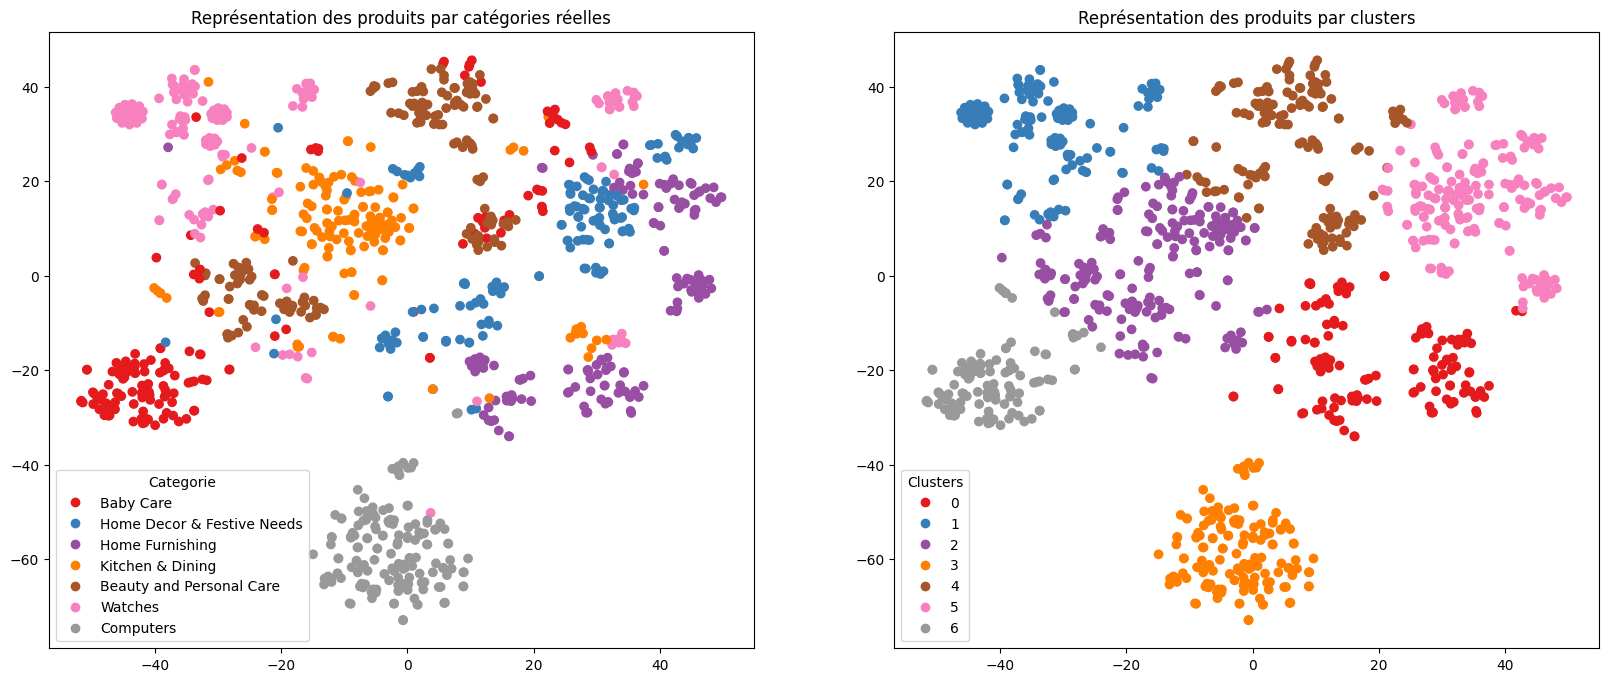

In [120]:
X_reduc = reduction_fct(ctf_transform, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['TF-IDF', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [4 0 5 6 1 2 3]
Accuracy : 0.0362

[[ 93   9   2  12  27   7   0]
 [  2  88  39  11   9   1   0]
 [  0  73  74   0   2   1   0]
 [  7   1  12 101  17  12   0]
 [  9   0   0  51  90   0   0]
 [  4  21   8  11   1 104   1]
 [  0   0   2   0   0   0 148]]

              precision    recall  f1-score   support

           0       0.81      0.62      0.70       150
           1       0.46      0.59      0.51       150
           2       0.54      0.49      0.52       150
           3       0.54      0.67      0.60       150
           4       0.62      0.60      0.61       150
           5       0.83      0.69      0.76       150
           6       0.99      0.99      0.99       150

    accuracy                           0.66      1050
   macro avg       0.68      0.66      0.67      1050
weighted avg       0.68      0.66      0.67      1050



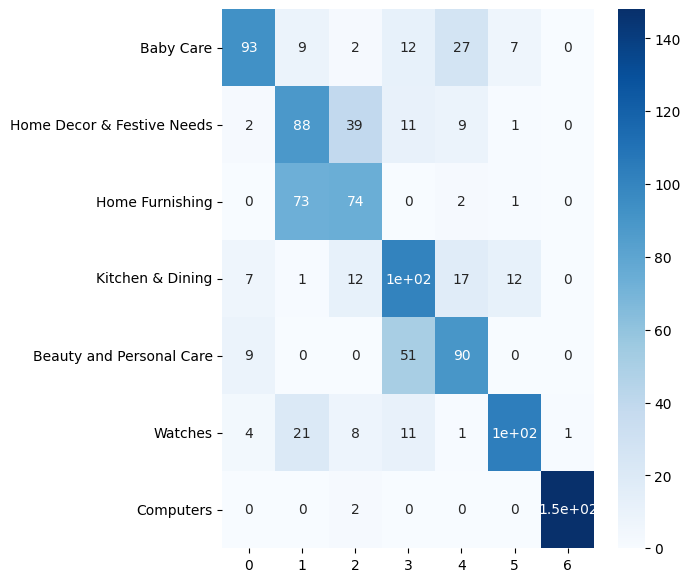

In [121]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(ctf_transform)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

## 2. Word embedding

### A. Word2Vec (CBoW)

#### Création et paramètrage du modèle

In [122]:
w2v_size = 1200
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100
maxlen = Max_len
sentences = clean_data['clean_description'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

print("Création du modèle ...")
w2v_model = gensim.models.Word2Vec(min_count = w2v_min_count, window = w2v_window,
                                                vector_size = w2v_size,
                                                sg = 0,
                                                seed = 42,
                                                workers = 1)

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Taille vocabulaire : %i" % len(w2v_words))
print("Modèle entraîné")

Création du modèle ...
Taille vocabulaire : 4154
Modèle entraîné


In [123]:
print("Entraînement du Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen = maxlen,
                                                     padding = 'post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Nombre d'occurences uniques de mots : %i" % num_words)

Entraînement du Tokenizer ...
Nombre d'occurences uniques de mots : 4155


In [124]:
print("Création de la matrice d'embedding ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in w2v_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Format matrice d'embedding : %s" % str(embedding_matrix.shape))

Création de la matrice d'embedding ...
Word embedding rate :  1.0
Format matrice d'embedding : (4155, 1200)


In [125]:
input = Input(shape = (len(x_sentences), maxlen), dtype = 'float64')
word_input = Input(shape  =(maxlen,), dtype = 'float64')
word_embedding = Embedding(input_dim = vocab_size,
                           output_dim = w2v_size,
                           weights = [embedding_matrix],
                           input_length = maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 3588)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 3588, 1200)        4986000   
                                                                 
 global_average_pooling1d_2   (None, 1200)             0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 4,986,000
Trainable params: 4,986,000
Non-trainable params: 0
_________________________________________________________________


In [126]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 3s 90ms/step


(1050, 1200)

#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 1200
Number of dimensions after TSVD (99% var. explained): 49
ARI :  0.0661


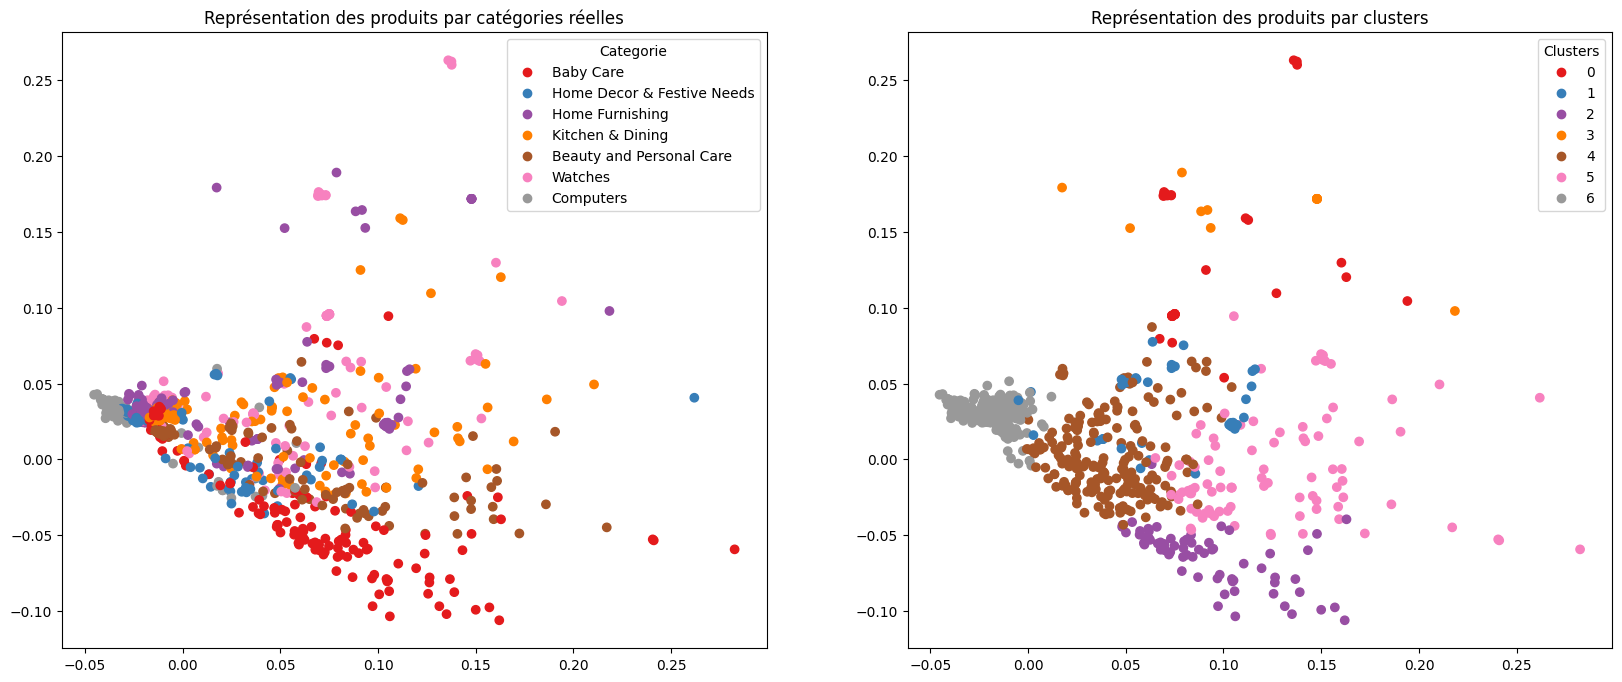

In [127]:
X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['Word2Vec', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.3654


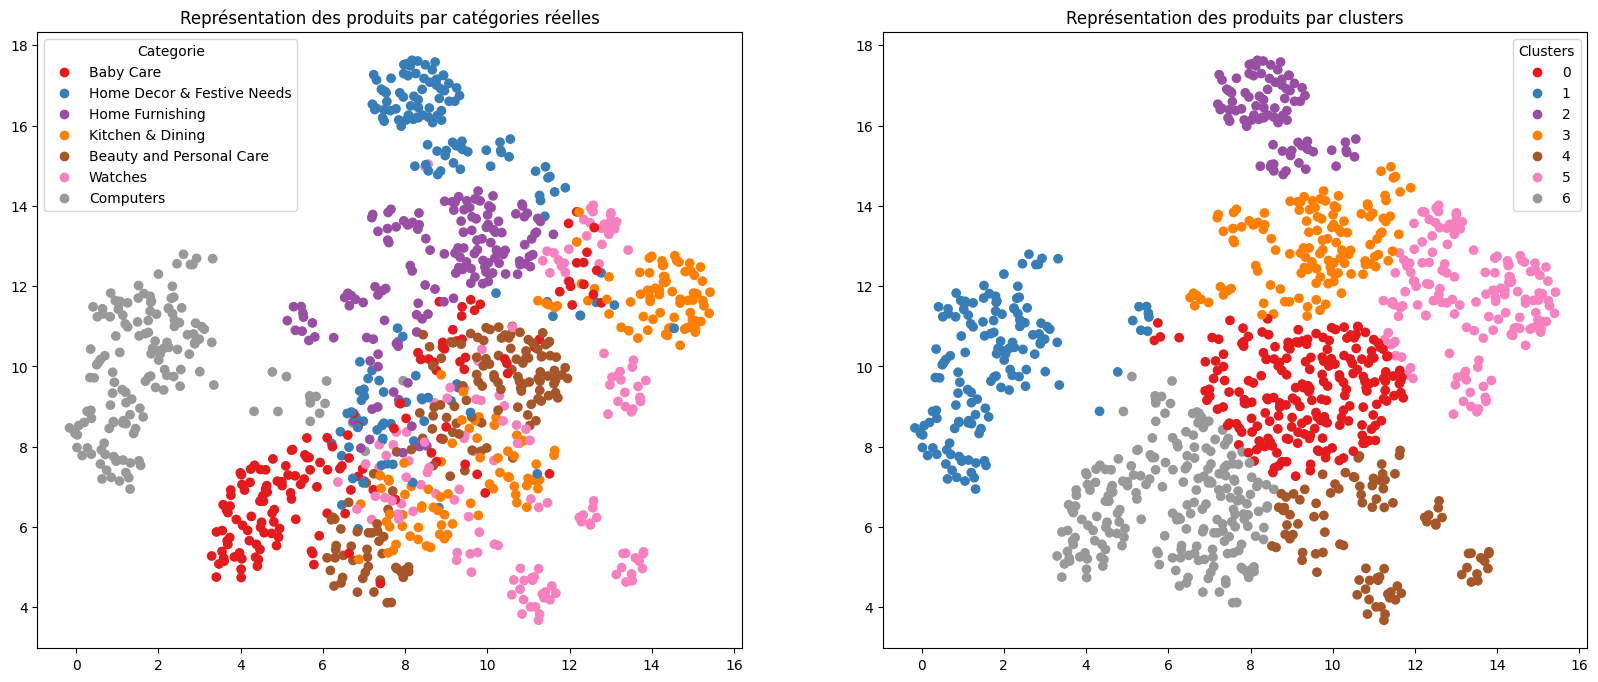

In [128]:
X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['Word2Vec', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.3697


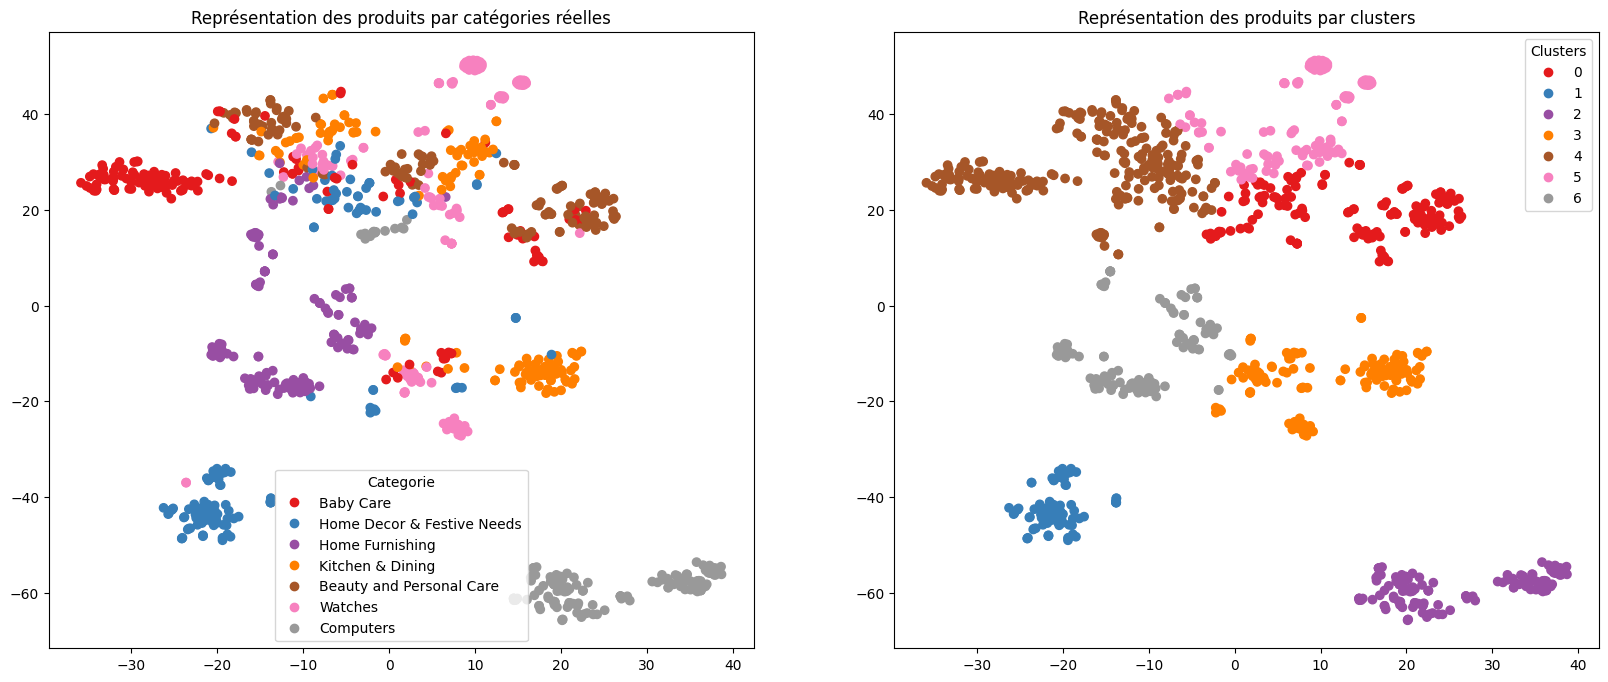

In [129]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['Word2Vec', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [3 0 6 1 5 4 2]
Accuracy : 0.0867

[[102   0   0  14  29   5   0]
 [ 36  86   3  15   9   1   0]
 [ 26   0 123   0   1   0   0]
 [ 24   0   0  76  12  38   0]
 [ 47   0   0   0  82  21   0]
 [ 23   2   6  42  20  57   0]
 [  2   0   0   0  14   0 134]]

              precision    recall  f1-score   support

           0       0.39      0.68      0.50       150
           1       0.98      0.57      0.72       150
           2       0.93      0.82      0.87       150
           3       0.52      0.51      0.51       150
           4       0.49      0.55      0.52       150
           5       0.47      0.38      0.42       150
           6       1.00      0.89      0.94       150

    accuracy                           0.63      1050
   macro avg       0.68      0.63      0.64      1050
weighted avg       0.68      0.63      0.64      1050



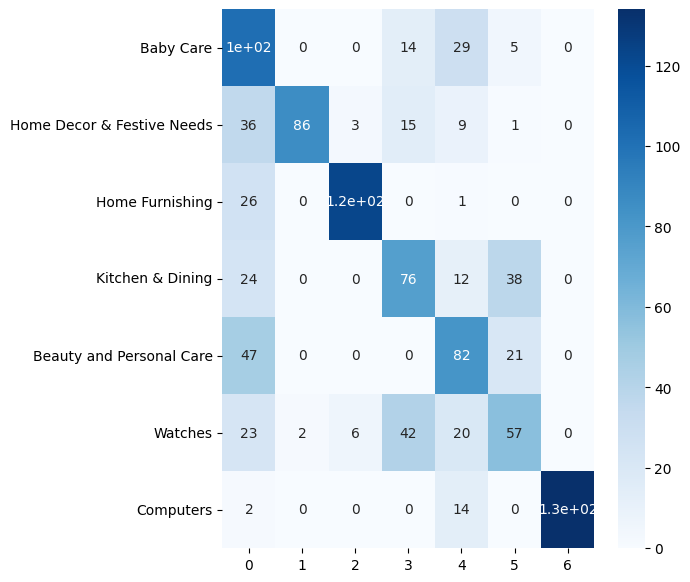

In [130]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(embeddings)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### B. FastText (CBoW)

#### Préparation du modèle

In [131]:
FT_size = 600
print("Création et préparation du modèle ...")
FT_model = gensim.models.FastText(min_count = w2v_min_count, window = w2v_window,
                                  vector_size = FT_size,
                                  seed = 42,
                                  sg = 0,
                                  workers = 4)

FT_model.build_vocab(sentences)
FT_model.train(sentences, total_examples = FT_model.corpus_count,
               epochs = w2v_epochs)
model_vectors = FT_model.wv
FT_words = model_vectors.index_to_key
print("Taille vocabulaire : %i" % len(FT_words))
print("Modèle entraîné")

Création et préparation du modèle ...
Taille vocabulaire : 4154
Modèle entraîné


In [132]:
print("Creéation matrice d'embedding ...")

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, FT_size))
i = 0
j = 0

for word, idx in word_index.items():
    i += 1
    if word in FT_words:
        j += 1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]

word_rate = np.round(j/i, 4)
print("Word embedding rate : ", word_rate)
print("Format matrice embedding : %s" % str(embedding_matrix.shape))

Creéation matrice d'embedding ...
Word embedding rate :  1.0
Format matrice embedding : (4155, 600)


In [133]:
input = Input(shape=(len(x_sentences), maxlen), dtype = 'float64')
word_input = Input(shape = (maxlen,), dtype = 'float64')
word_embedding = Embedding(input_dim = vocab_size,
                           output_dim = FT_size,
                           weights = [embedding_matrix],
                           input_length = maxlen)(word_input)
word_vec = GlobalAveragePooling1D()(word_embedding)
embed_model = Model([word_input], word_vec)

embed_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3588)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 3588, 600)         2493000   
                                                                 
 global_average_pooling1d_3   (None, 600)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
Total params: 2,493,000
Trainable params: 2,493,000
Non-trainable params: 0
_________________________________________________________________


In [134]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 2s 50ms/step


(1050, 600)

#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 600
Number of dimensions after TSVD (99% var. explained): 47
ARI :  0.0568


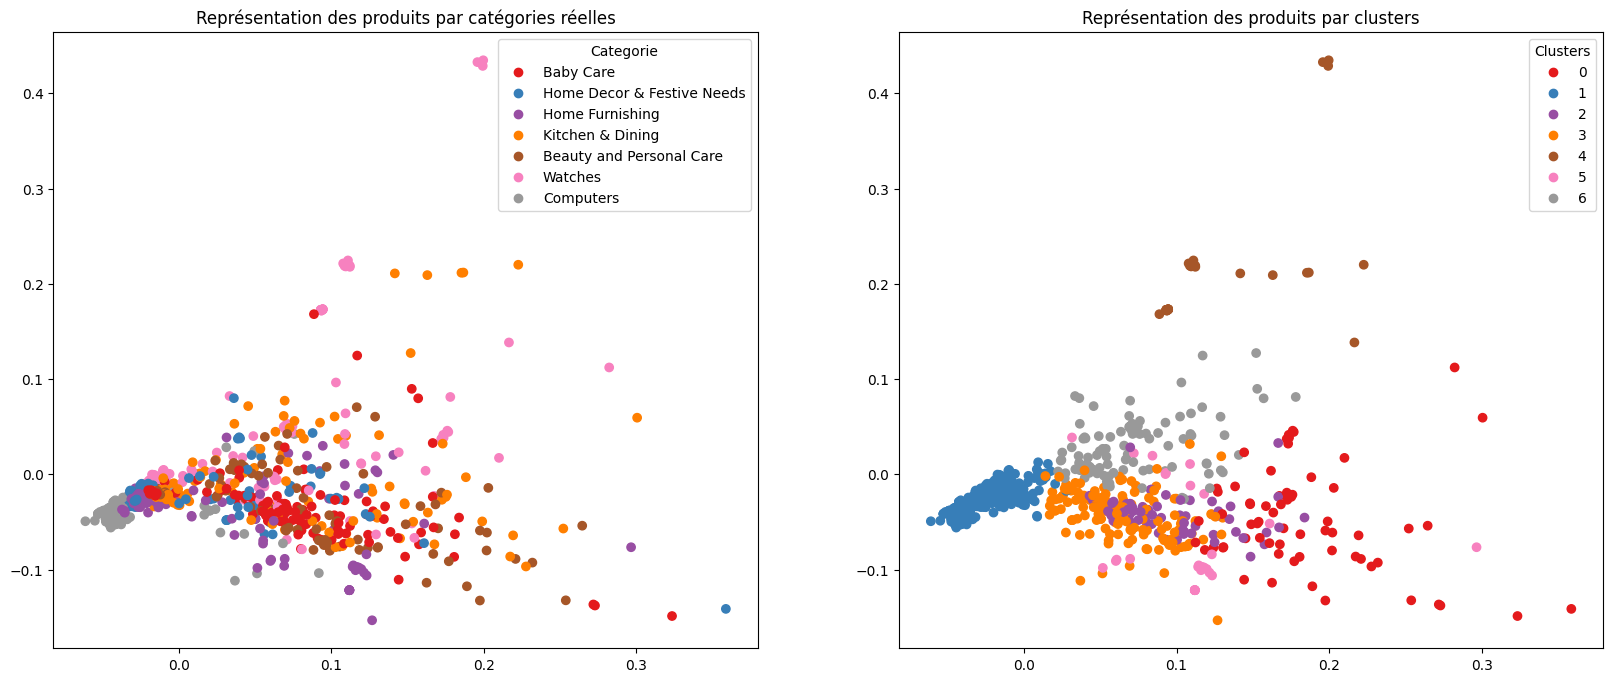

In [135]:
X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['FastText', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.2971


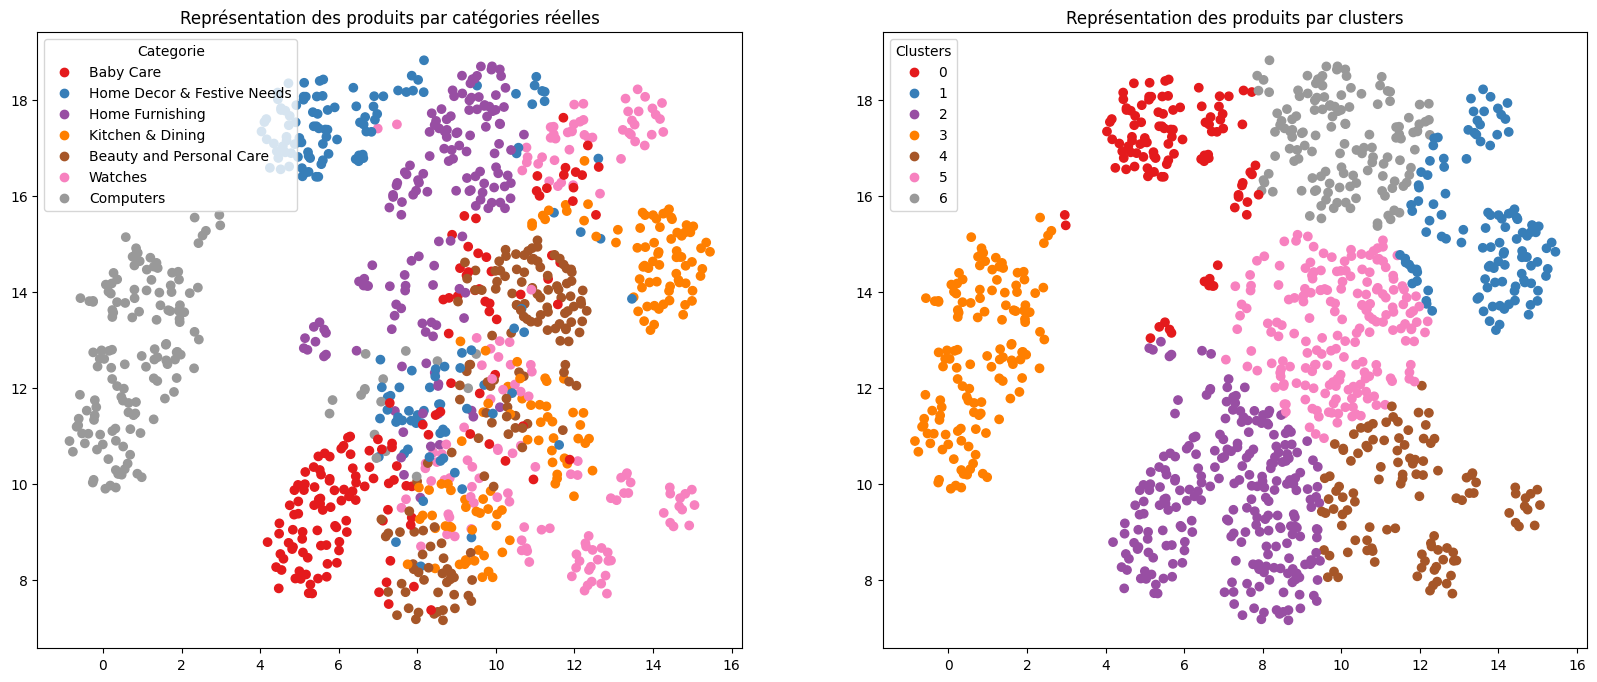

In [136]:
X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['FastText', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.3292


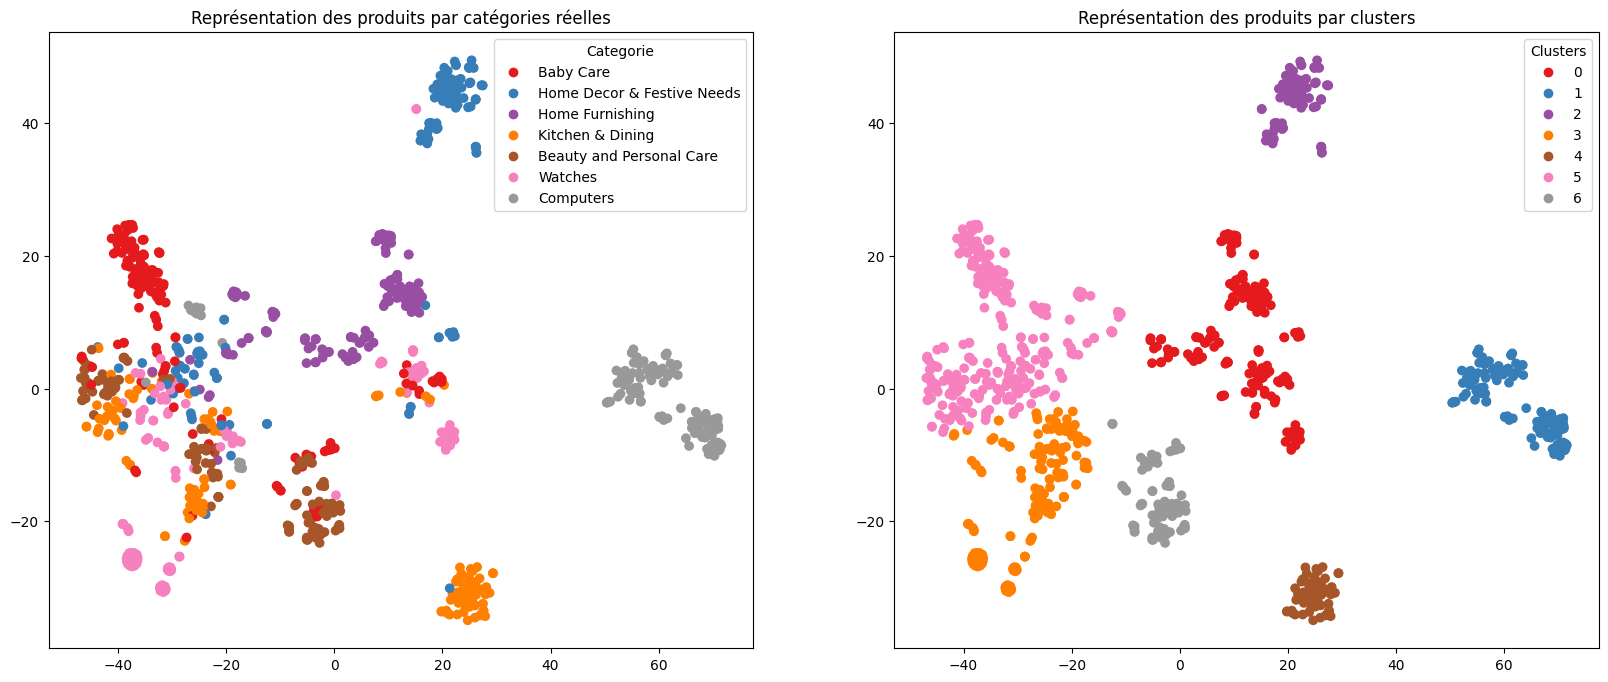

In [137]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['FastText', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [3 0 1 6 5 2 4]
Accuracy : 0.1095

[[103   0  14   0  25   8   0]
 [ 38  86  14   1   3   8   0]
 [ 38   0 111   0   0   1   0]
 [ 30   0  11  65   0  44   0]
 [ 47   0   0   0  74  29   0]
 [ 23   2  48   0   1  76   0]
 [ 12   0   0   0   0   4 134]]

              precision    recall  f1-score   support

           0       0.35      0.69      0.47       150
           1       0.98      0.57      0.72       150
           2       0.56      0.74      0.64       150
           3       0.98      0.43      0.60       150
           4       0.72      0.49      0.58       150
           5       0.45      0.51      0.48       150
           6       1.00      0.89      0.94       150

    accuracy                           0.62      1050
   macro avg       0.72      0.62      0.63      1050
weighted avg       0.72      0.62      0.63      1050



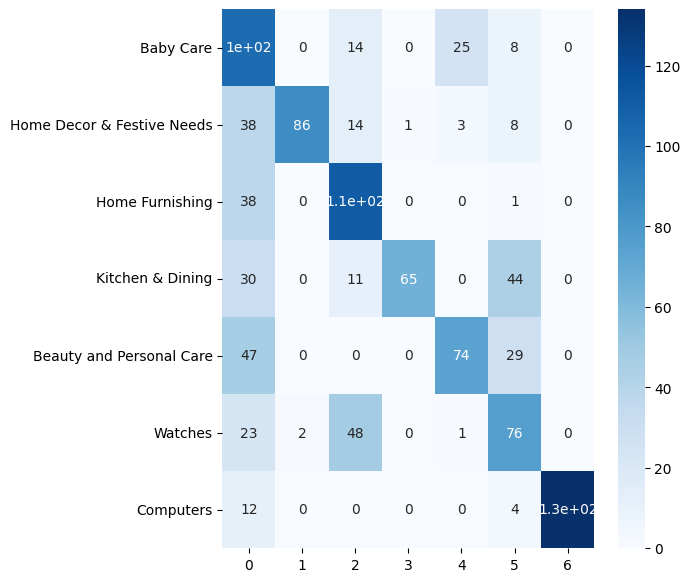

In [138]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(embeddings)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### C. BERT (bert base uncased)

In [139]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
False


In [140]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFBertModel.from_pretrained(model_type)
sentences = clean_data['clean_description'].to_list()

loading configuration file config.json from cache at C:\Users\JayCo/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file tf_model.h5 from cache at C:\Users\JayCo/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\tf_model.h5
Some layers from the mode

In [141]:
# Création des features
features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

loading configuration file config.json from cache at C:\Users\JayCo/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\JayCo/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

1/1 [==============================] - 0s 372ms/step
temps traitement :  46.0


#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 768
Number of dimensions after TSVD (99% var. explained): 315
ARI :  0.2587


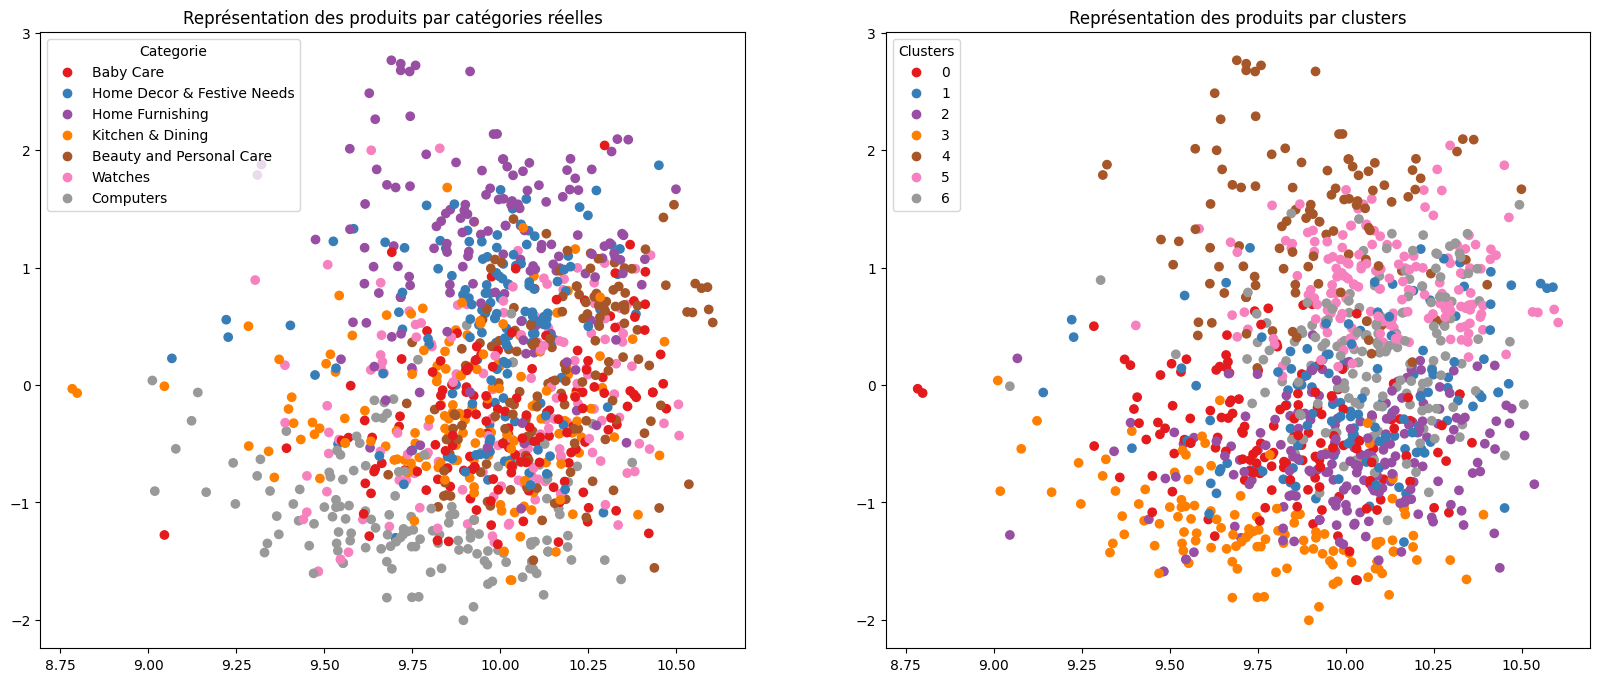

In [142]:
X_reduc = reduction_fct(features_bert, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['BERT base uncased', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.3064


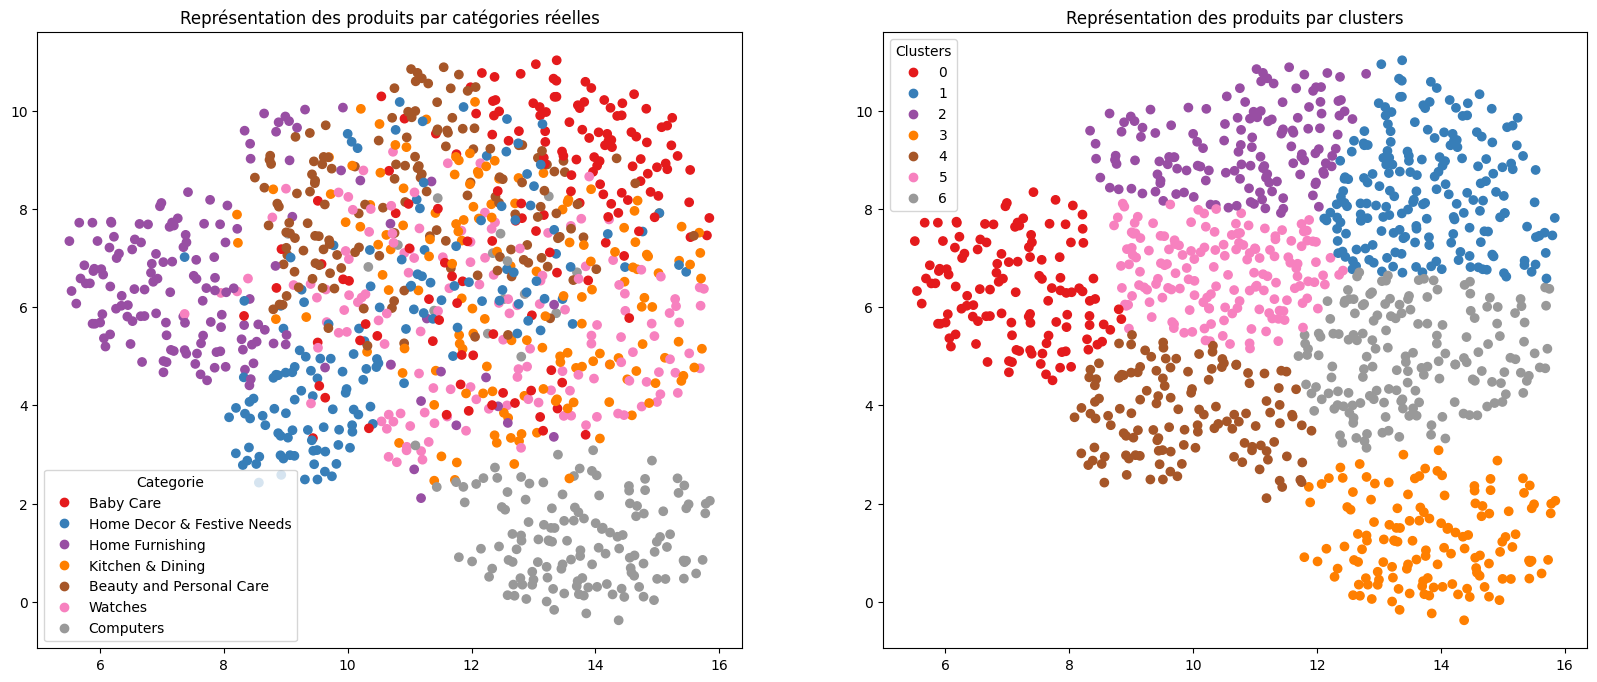

In [143]:
X_reduc = reduction_fct(features_bert, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['BERT base uncased', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.3627


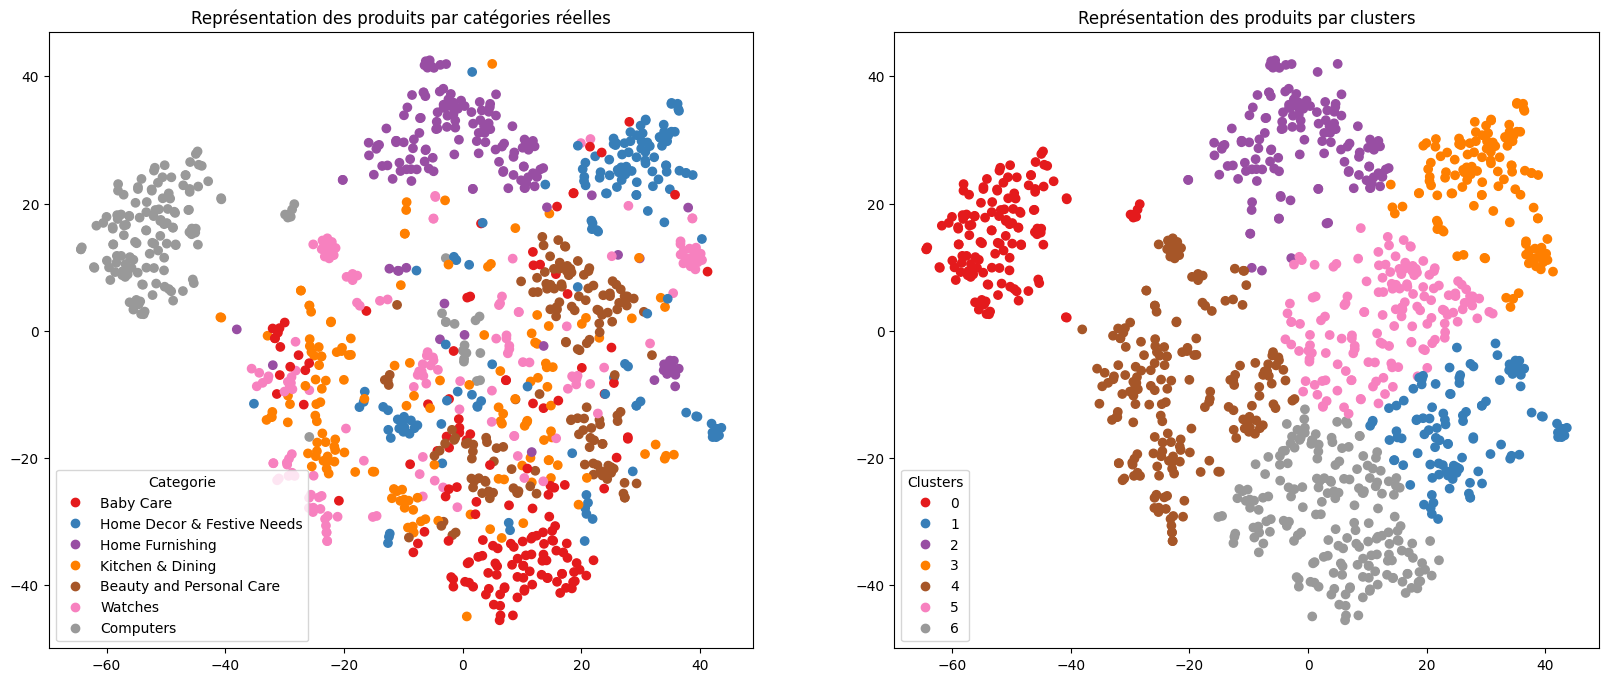

In [144]:
X_reduc = reduction_fct(features_bert, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['BERT base uncased', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentatino via T-SNE

Correspondance des clusters :  [0 2 6 4 4 5 1]
Accuracy : 0.2571

[[101   8   1   0  22  18   0]
 [  8  82   3   0  38  19   0]
 [  1   5 123   0  16   5   0]
 [ 30   4   6   0  42  66   2]
 [ 39   0   0   0 106   5   0]
 [ 15  23   4   0  28  80   0]
 [  0   0   1   0  14   1 134]]

              precision    recall  f1-score   support

           0       0.52      0.67      0.59       150
           1       0.67      0.55      0.60       150
           2       0.89      0.82      0.85       150
           3       0.00      0.00      0.00       150
           4       0.40      0.71      0.51       150
           5       0.41      0.53      0.47       150
           6       0.99      0.89      0.94       150

    accuracy                           0.60      1050
   macro avg       0.55      0.60      0.57      1050
weighted avg       0.55      0.60      0.57      1050



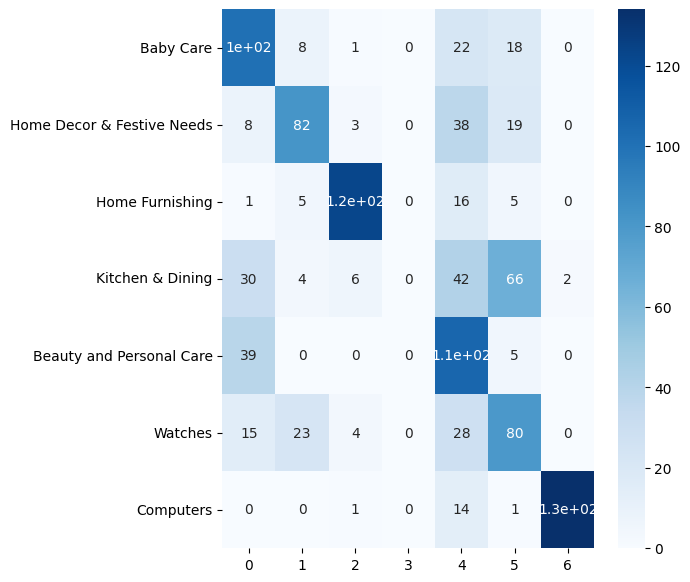

In [145]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(features_bert)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### D. BERT (Tensorflow hub)

#### Paramétrage du modèle

In [146]:
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [147]:
bert_layer

In [148]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences,
                                                         max_length, batch_size, mode='TFhub')

loading configuration file config.json from cache at C:\Users\JayCo/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file vocab.txt from cache at C:\Users\JayCo/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\vocab.t

temps traitement :  43.0


#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 768
Number of dimensions after TSVD (99% var. explained): 315
ARI :  0.2525


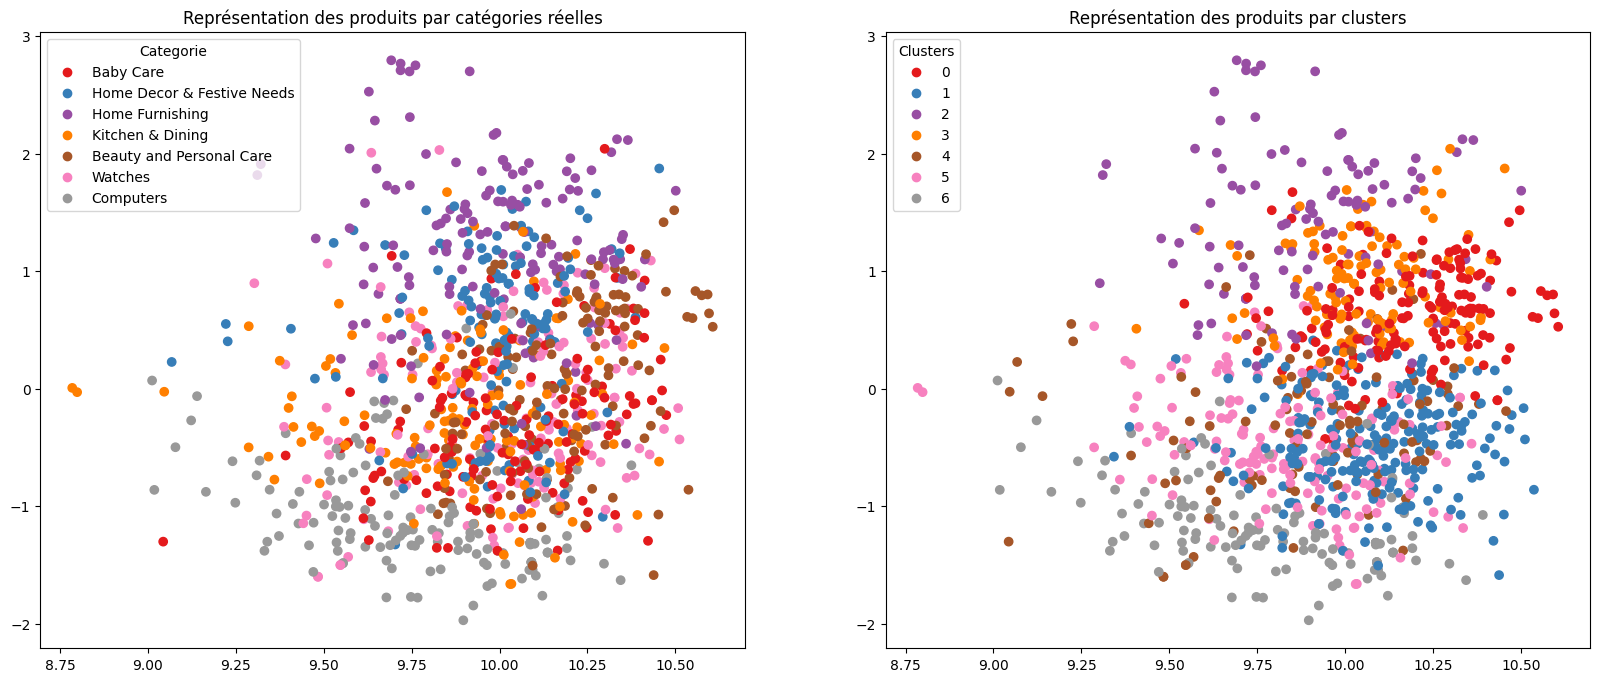

In [149]:
X_reduc = reduction_fct(features_bert, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['BERT TF hub', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.2896


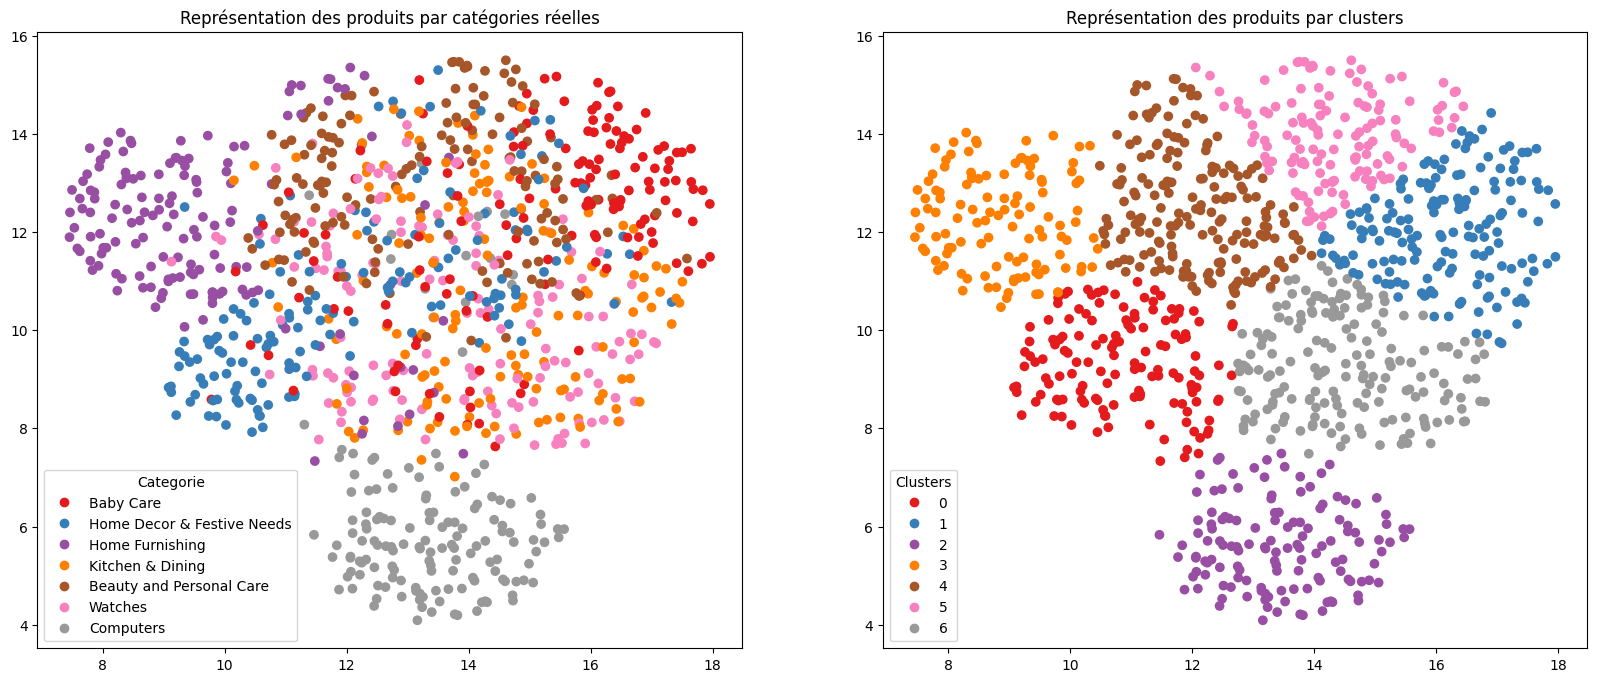

In [150]:
X_reduc = reduction_fct(features_bert, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['BERT TF hub', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.3626


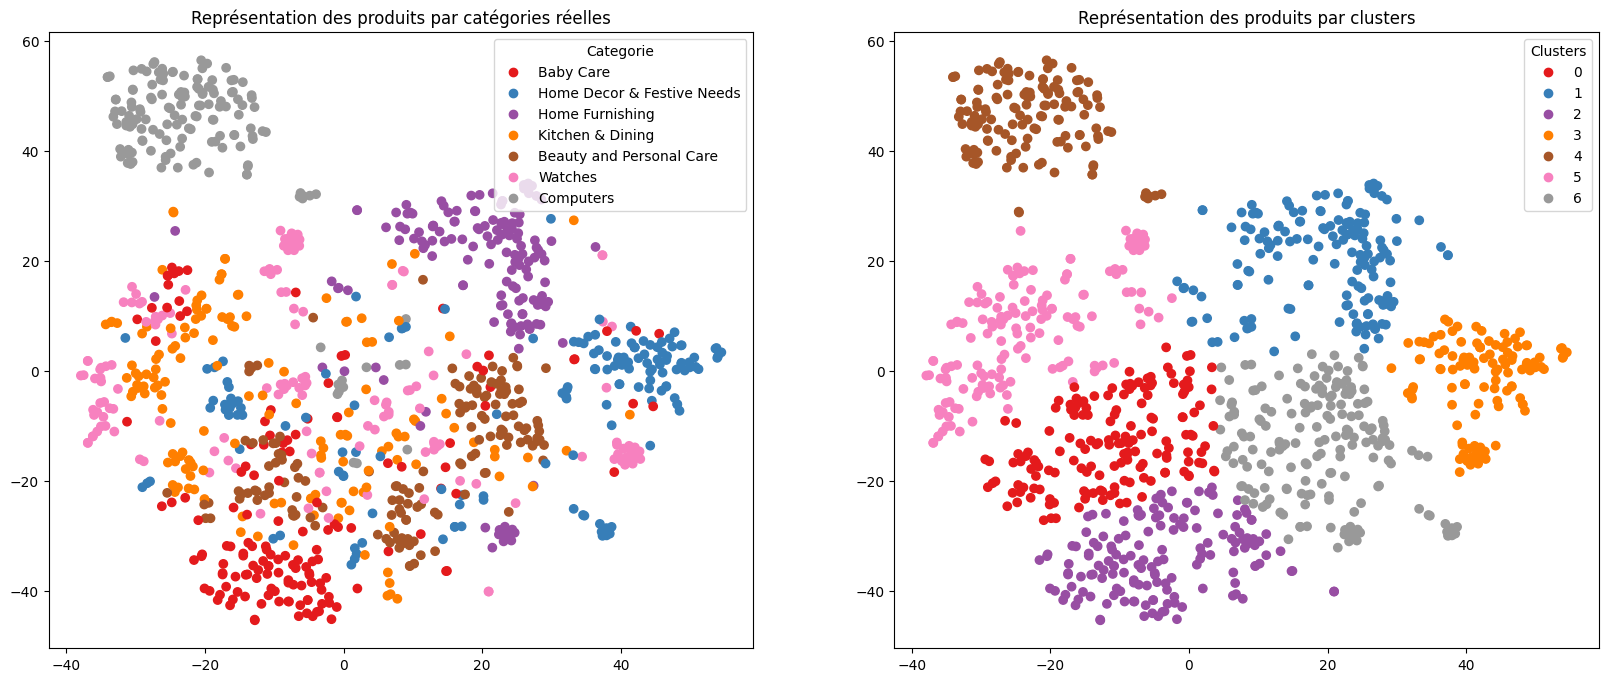

In [151]:
X_reduc = reduction_fct(features_bert, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['BERT TF hub', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [2 1 3 5 6 4 0]
Accuracy : 0.1581

[[ 89   8   1  25  11  16   0]
 [  8  80   8  26  23   5   0]
 [  0   1 128   2  17   2   0]
 [ 21   1  10  38  19  59   2]
 [ 30   1   1  33  80   5   0]
 [  7  19   7  27  24  66   0]
 [  0   0   1   9   3   0 137]]

              precision    recall  f1-score   support

           0       0.57      0.59      0.58       150
           1       0.73      0.53      0.62       150
           2       0.82      0.85      0.84       150
           3       0.24      0.25      0.25       150
           4       0.45      0.53      0.49       150
           5       0.43      0.44      0.44       150
           6       0.99      0.91      0.95       150

    accuracy                           0.59      1050
   macro avg       0.60      0.59      0.59      1050
weighted avg       0.60      0.59      0.59      1050



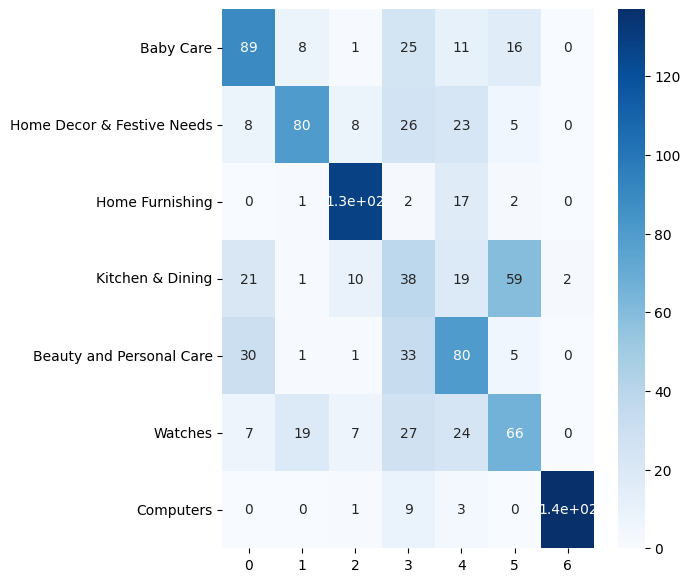

In [152]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(features_bert)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

## 3. Sentence embedding

### A. USE (Universal Sentence Encoder)

#### Paramétrage du modèle

In [153]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.12.0
2.12.0
Num GPUs Available:  0
False


In [154]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

batch_size = 10
sentences = clean_data['clean_description'].to_list()

features_USE = feature_USE_fct(sentences, batch_size)

#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 512
Number of dimensions after TSVD (99% var. explained): 307
ARI :  0.2868


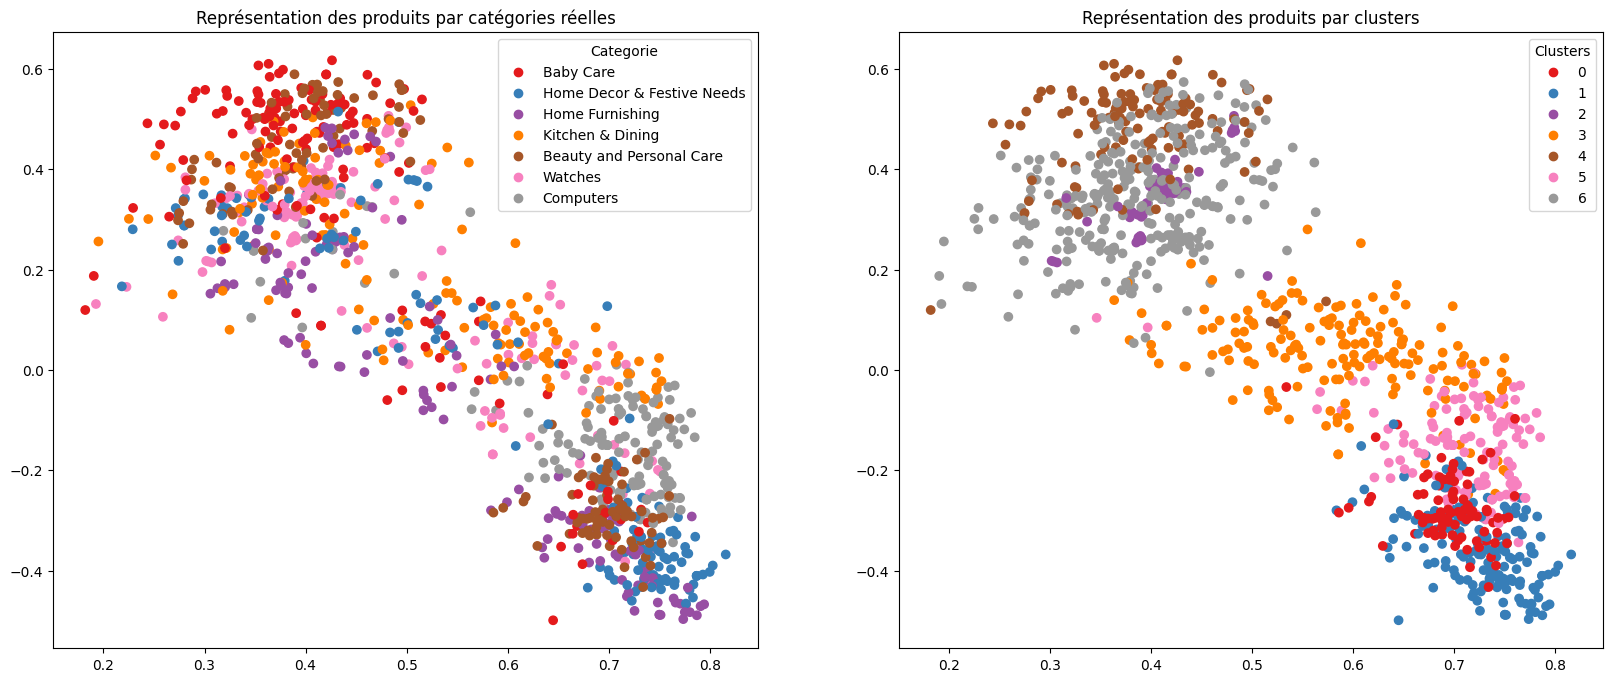

In [155]:
X_reduc = reduction_fct(features_USE, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['USE', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.3935


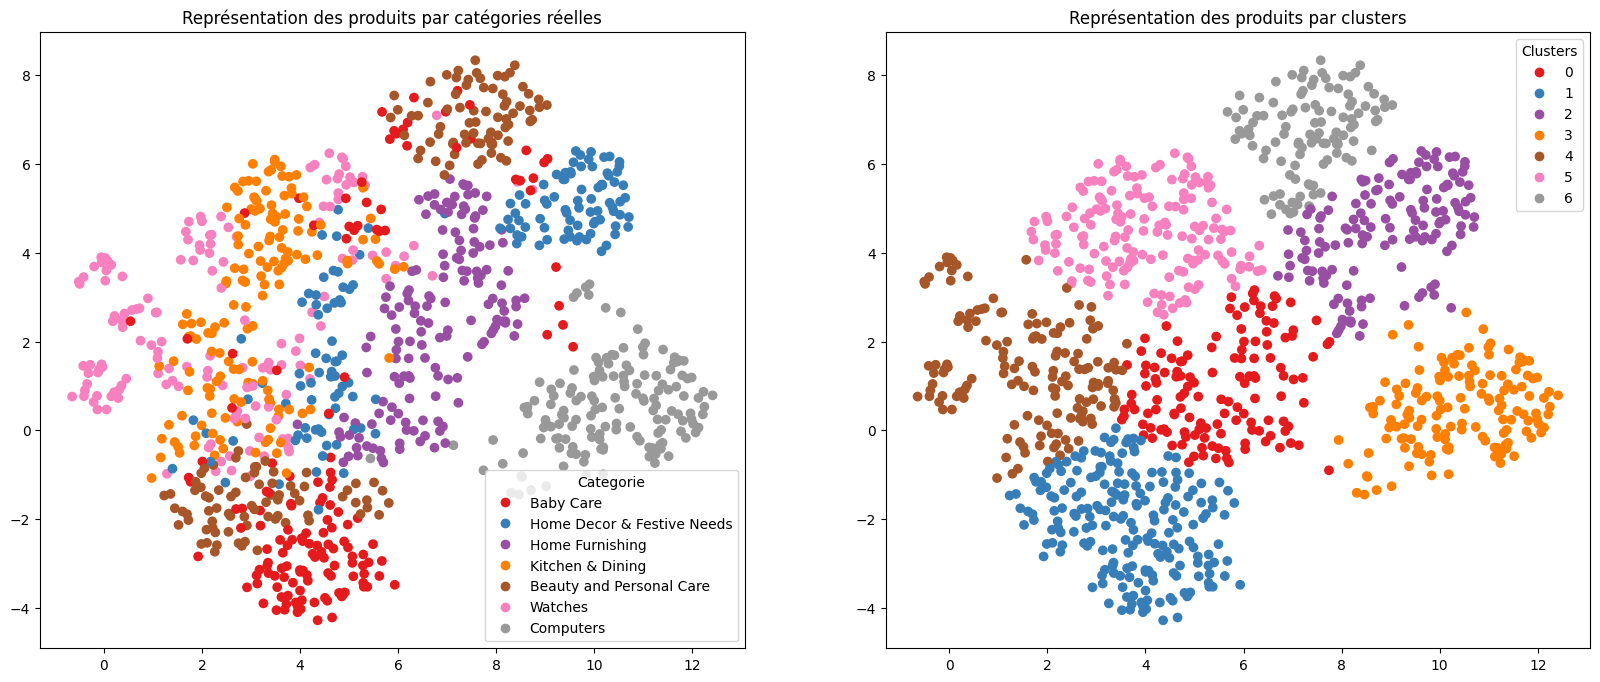

In [156]:
X_reduc = reduction_fct(features_USE, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['USE', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.4273


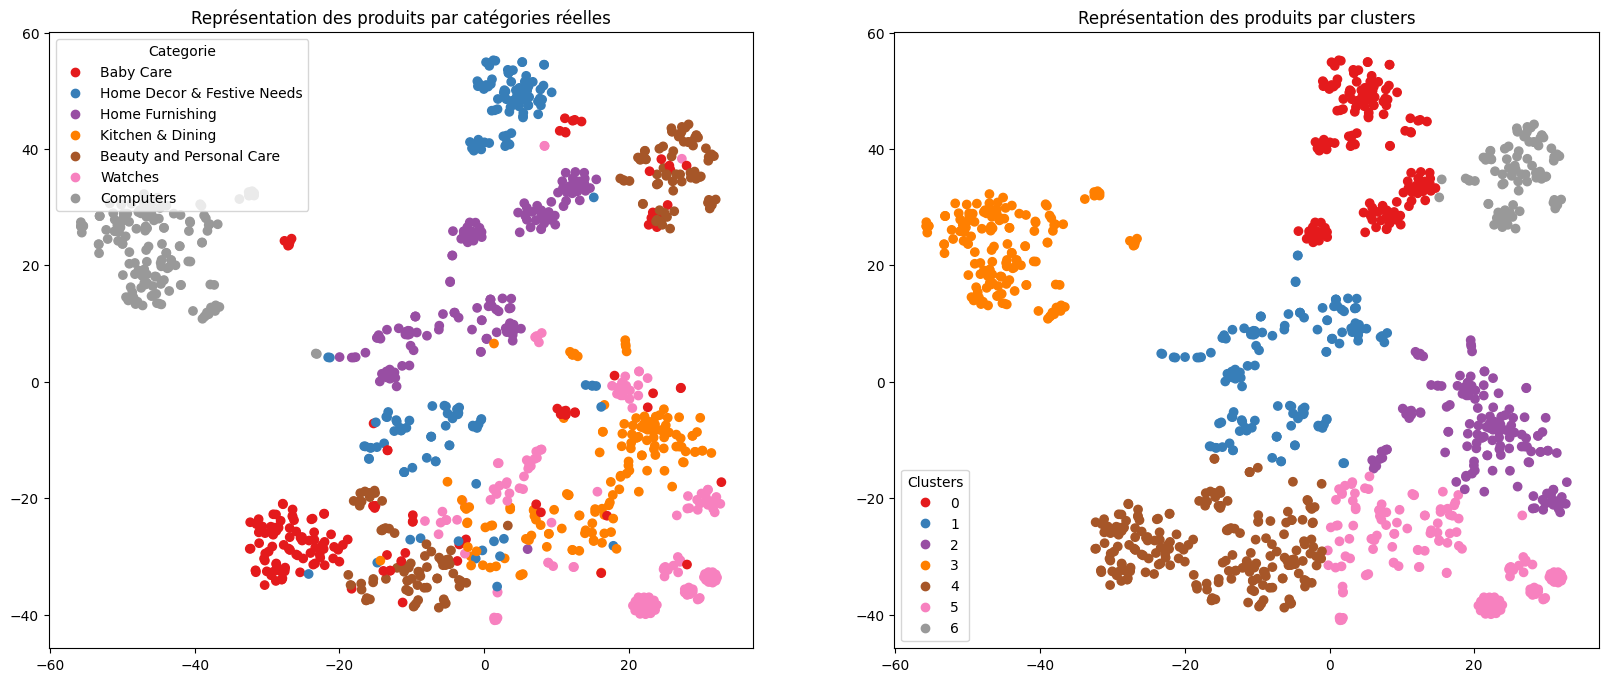

In [157]:
X_reduc = reduction_fct(features_USE, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['USE', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [3 6 5 4 2 1 0]
Accuracy : 0.0162

[[103   7   3  14  13   5   5]
 [ 13  79  46   5   1   6   0]
 [  0  67  81   0   1   1   0]
 [ 12   0   1  83   0  54   0]
 [ 75   0   0   0  74   1   0]
 [  9   2   8  48   1  82   0]
 [  0   0   2   0   0   0 148]]

              precision    recall  f1-score   support

           0       0.49      0.69      0.57       150
           1       0.51      0.53      0.52       150
           2       0.57      0.54      0.56       150
           3       0.55      0.55      0.55       150
           4       0.82      0.49      0.62       150
           5       0.55      0.55      0.55       150
           6       0.97      0.99      0.98       150

    accuracy                           0.62      1050
   macro avg       0.64      0.62      0.62      1050
weighted avg       0.64      0.62      0.62      1050



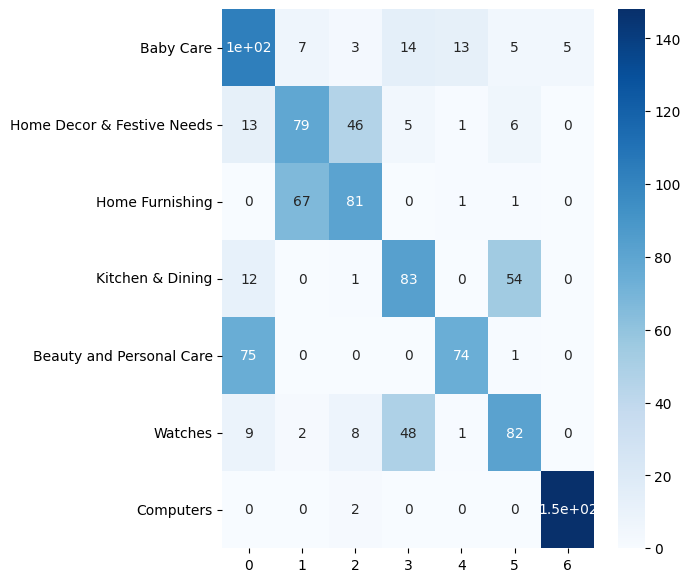

In [158]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(features_USE)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

### B. Sentence BERT

#### Préparation du modèle

In [159]:
model = SentenceTransformer('all-mpnet-base-v2')
sentences = clean_data['clean_description'].to_list()
embeddings = model.encode(sentences)

loading configuration file C:\Users\JayCo/.cache\torch\sentence_transformers\sentence-transformers_all-mpnet-base-v2\config.json
Model config MPNetConfig {
  "_name_or_path": "C:\\Users\\JayCo/.cache\\torch\\sentence_transformers\\sentence-transformers_all-mpnet-base-v2\\",
  "architectures": [
    "MPNetForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "mpnet",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "relative_attention_num_buckets": 32,
  "transformers_version": "4.28.1",
  "vocab_size": 30527
}

loading weights file C:\Users\JayCo/.cache\torch\sentence_transformers\sentence-transformers_all-mpnet-base-v2\pytorch_model.bin
All model checkpoint weights were used when initializing MPNetModel.

#### SVD et KMeans (n_clusters = 7)

Number of dimensions before TSVD: 768
Number of dimensions after TSVD (99% var. explained): 222
ARI :  0.3091


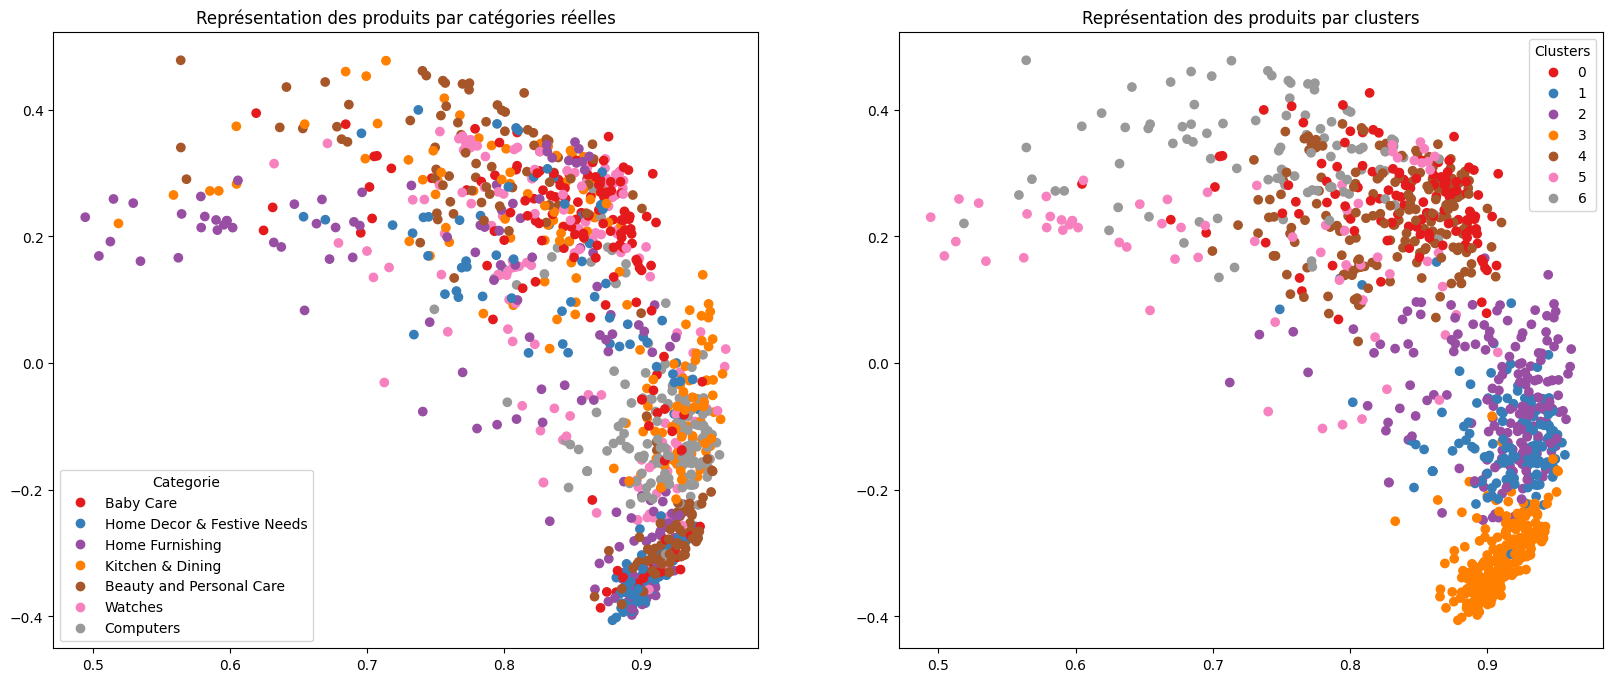

In [160]:
X_reduc = reduction_fct(embeddings, reduc='SVD')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['Sentence BERT', 'SVD', ARI]], axis = 0)

#### UMAP et KMeans (n_clusters = 7)

ARI :  0.3157


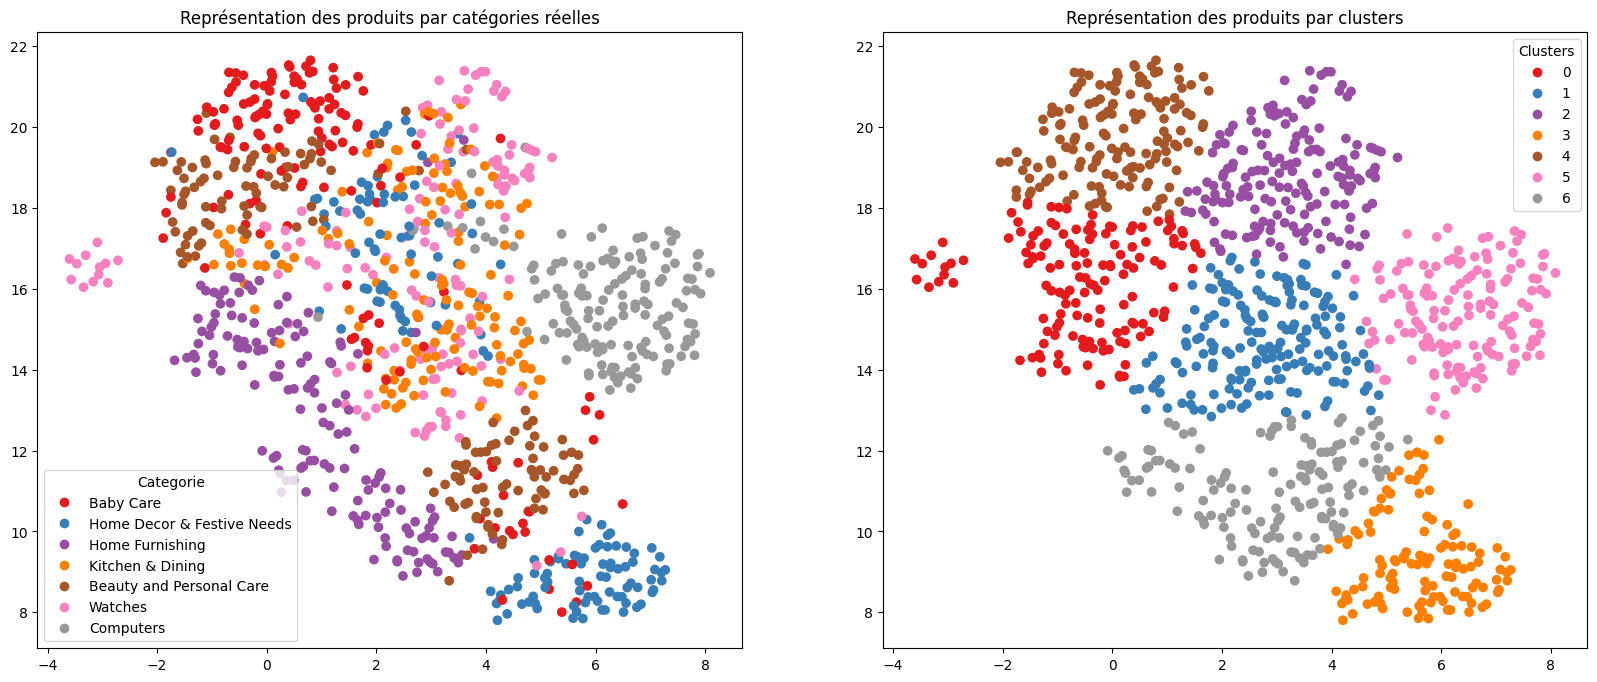

In [161]:
X_reduc = reduction_fct(embeddings, reduc='UMAP')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['Sentence BERT', 'UMAP', ARI]], axis = 0)

#### T-SNE et KMeans (n_clusters = 7)

ARI :  0.3871


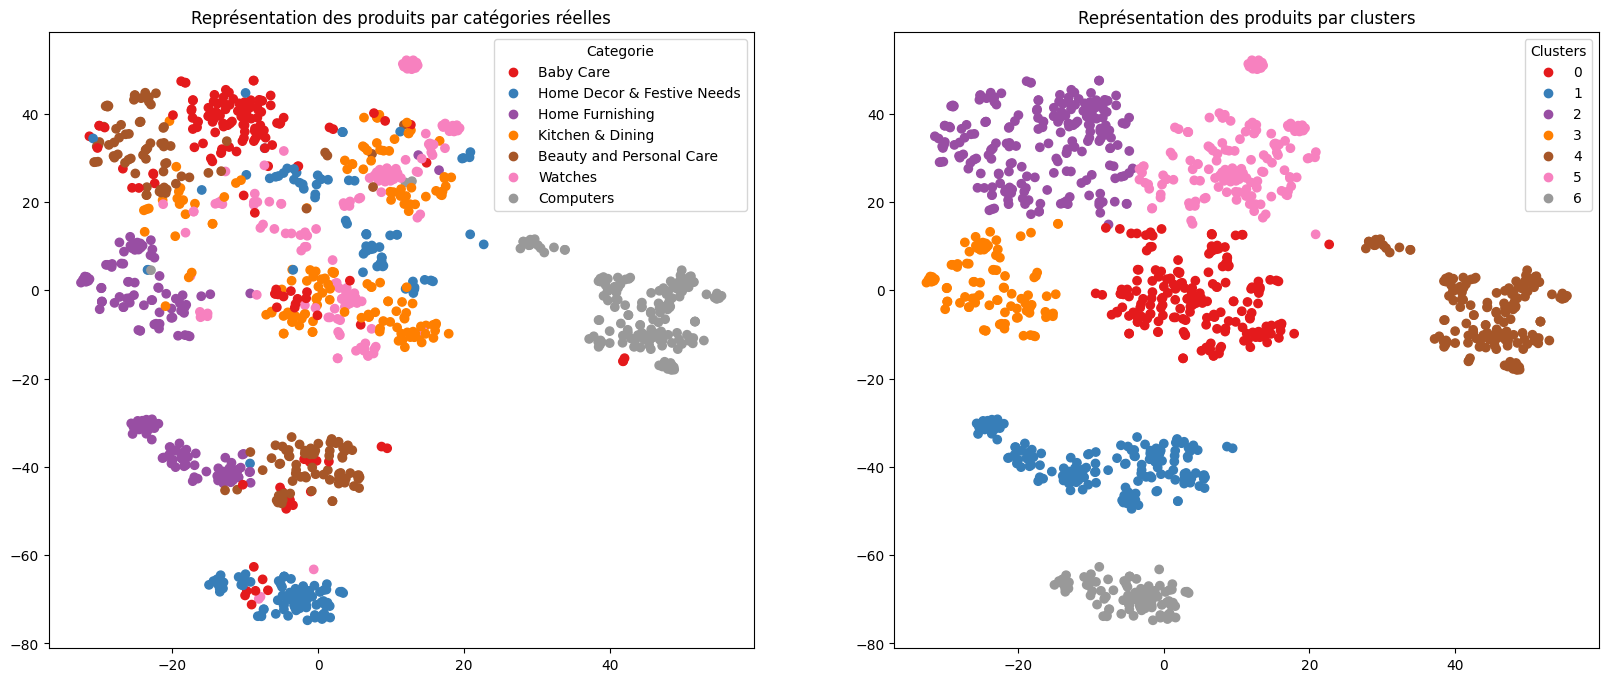

In [162]:
X_reduc = reduction_fct(embeddings, reduc='TSNE')
ARI, labels = kmeans_fct(X_reduc, clean_data['main_cat'])
reduc_visu_fct(X_reduc, clean_data['main_cat'], labels)

Results = np.append(Results, [['Sentence BERT', 'T-SNE', ARI]], axis = 0)

#### Evaluation de la segmentation via T-SNE

Correspondance des clusters :  [3 2 1 6 0 4 5]
Accuracy : 0.0848

[[102   7   0  15  15   8   3]
 [ 10  79   2  32   1  26   0]
 [  0   0  79   1  68   2   0]
 [ 16   0   7  82   0  45   0]
 [ 70   0   0   0  74   6   0]
 [ 19   3   8  54   0  66   0]
 [  0   0   1   0   0   2 147]]

              precision    recall  f1-score   support

           0       0.47      0.68      0.56       150
           1       0.89      0.53      0.66       150
           2       0.81      0.53      0.64       150
           3       0.45      0.55      0.49       150
           4       0.47      0.49      0.48       150
           5       0.43      0.44      0.43       150
           6       0.98      0.98      0.98       150

    accuracy                           0.60      1050
   macro avg       0.64      0.60      0.61      1050
weighted avg       0.64      0.60      0.61      1050



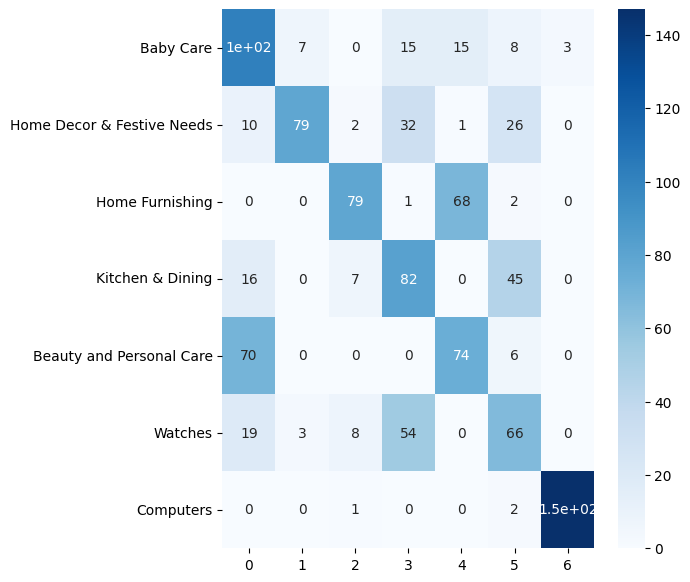

In [163]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=2000,
                    init='random', learning_rate=200, random_state=42)
reduc_X = tsne.fit_transform(embeddings)

# Clustering KMeans (7 clusters)
cls = cluster.KMeans(n_clusters=7, n_init=100)
cls.fit(reduc_X)

# Création Dataframe réduite via T-SNE et segmentée via KMeans
df_tsne = pd.DataFrame(reduc_X, columns = ['tsne1', 'tsne2'])
df_tsne['class'] = clean_data['main_cat']
df_tsne['cluster'] = cls.labels_

# Encodage de la catégorie réelle
encoder = preprocessing.LabelEncoder()
df_tsne['cat'] = encoder.fit_transform(df_tsne['class'])

# Evaluation du modèle : score ARI et matrice de confusion
CM_matrix(df_tsne, 'cat')

# BILAN : comparaison des différents modèles

#### Tableau des scores ARI pour chaque modèle, et pour chaque méthode de réduction

In [ ]:
df_results = pd.DataFrame(Results, columns = ["Model", "Reduction", "ARI"])
df_results_sorted = df_results.sort_values(by='ARI', ascending=False)
df_results_sorted

#### Représentation graphique des résultats

Afin de conclure et de pouvoir comparer les diffrétentes méthodes de modélisation, nous représenterons graphiquement les scores ARI, selon chaque approche de réduction de dimension (UMAP, SVD et T-SNE).

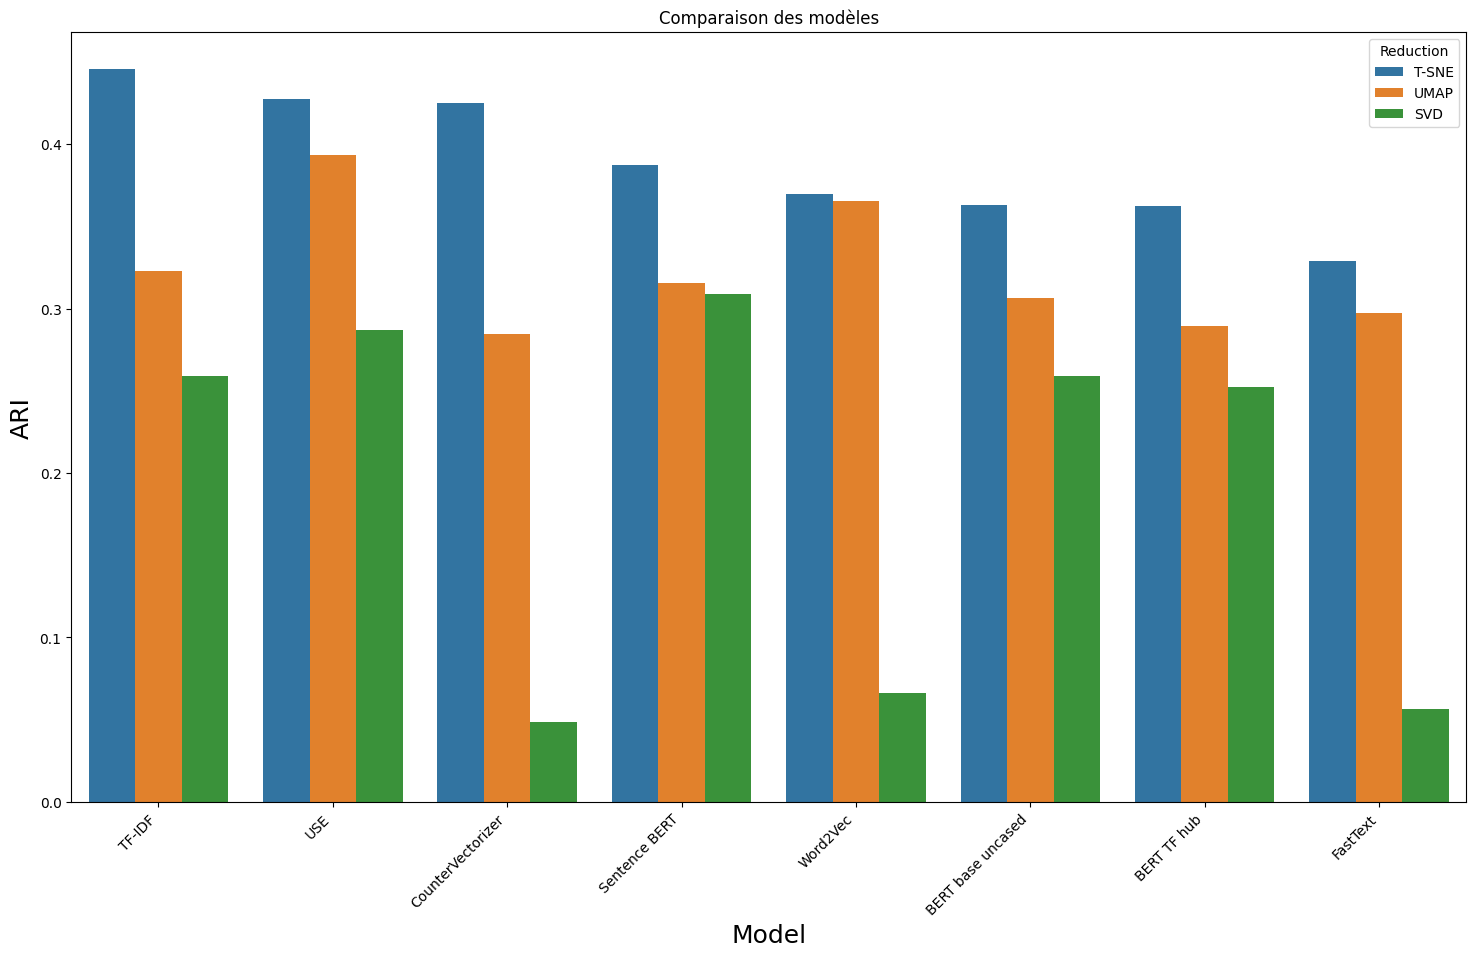

In [168]:
df_results['ARI'] = df_results['ARI'].astype(float)

plt.figure(figsize=(18, 10))

sns.barplot(data=df_results, x="Model", y="ARI", hue='Reduction')
plt.xticks(rotation=45, ha='right')
plt.title('Comparaison des modèles')
plt.xlabel('Model', fontsize=18)
plt.ylabel('ARI', fontsize=18)

plt.show()

#### Conclusion :  
  
Les scores ARI ne sont globalement pas très élevés.  La méthode faisant ressortir les meilleurs résultats est le TF-IDF, réduit via le T-SNE.  
Les résultats ne remettent pas en cause la faisabilité d'une classification automatisée, qu'il faudrait mener de manière supervisée afin d'en évaluer les résultats.